# **TPS: Racial Bias and Predicting Likelihood of Arrests**
Course: INF 2178 \
Group 63 - Eva Li, Purui Zhang

### **Import Libraries and Dataset**

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.stats.power as smp
import statsmodels.api as sm
from statsmodels.formula.api import ols

%matplotlib inline

In [2]:
tps = pd.read_csv("Arrests_and_Strip_Searches_(RBDC-ARR-TBL-001).csv")
tps.head()

,Arrest_Year,Arrest_Month,EventID,ArrestID,PersonID,Perceived_Race,Sex,Age_group__at_arrest_,Youth_at_arrest__under_18_years,ArrestLocDiv,...,Actions_at_arrest___Resisted__d,Actions_at_arrest___Mental_inst,Actions_at_arrest___Assaulted_o,Actions_at_arrest___Cooperative,SearchReason_CauseInjury,SearchReason_AssistEscape,SearchReason_PossessWeapons,SearchReason_PossessEvidence,ItemsFound,ObjectId
0,2020,July-Sept,1005907,6017884.0,326622,White,M,Aged 35 to 44 years,Not a youth,54,...,0,0,0,1,NaN,NaN,NaN,NaN,NaN,1
1,2020,July-Sept,1014562,6056669.0,326622,White,M,Aged 35 to 44 years,Not a youth,54,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,2
2,2020,Oct-Dec,1029922,6057065.0,326622,Unknown or Legacy,M,Aged 35 to 44 years,Not a youth,54,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,3
3,2021,Jan-Mar,1052190,6029059.0,327535,Black,M,Aged 25 to 34 years,Not a youth,XX,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,4
4,2021,Jan-Mar,1015512,6040372.0,327535,South Asian,M,Aged 25 to 34 years,Not a youth,XX,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,5


### **Data Processing**

As per the dataset information, there are instances in the dataset where there was a strip search but the data does not indicate that the booking took place. We can assume the booking has taken place. Therefore, we will replace 0 with 1 if strip search == 1.

In [3]:
# check if there are any instances where a person was strip searched but was not booked in record

tps[(tps["StripSearch"]==1) & (tps["Booked"]==0)]["Booked"].count()

572

In [4]:
# create a copy of the original dataset
processed_df = tps.copy()
processed_df.head()

,Arrest_Year,Arrest_Month,EventID,ArrestID,PersonID,Perceived_Race,Sex,Age_group__at_arrest_,Youth_at_arrest__under_18_years,ArrestLocDiv,...,Actions_at_arrest___Resisted__d,Actions_at_arrest___Mental_inst,Actions_at_arrest___Assaulted_o,Actions_at_arrest___Cooperative,SearchReason_CauseInjury,SearchReason_AssistEscape,SearchReason_PossessWeapons,SearchReason_PossessEvidence,ItemsFound,ObjectId
0,2020,July-Sept,1005907,6017884.0,326622,White,M,Aged 35 to 44 years,Not a youth,54,...,0,0,0,1,NaN,NaN,NaN,NaN,NaN,1
1,2020,July-Sept,1014562,6056669.0,326622,White,M,Aged 35 to 44 years,Not a youth,54,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,2
2,2020,Oct-Dec,1029922,6057065.0,326622,Unknown or Legacy,M,Aged 35 to 44 years,Not a youth,54,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,3
3,2021,Jan-Mar,1052190,6029059.0,327535,Black,M,Aged 25 to 34 years,Not a youth,XX,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,4
4,2021,Jan-Mar,1015512,6040372.0,327535,South Asian,M,Aged 25 to 34 years,Not a youth,XX,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,5


In [5]:
# define a function to modify the Booked column based on the StripSearch column
def modify_booked(row):
    if row['StripSearch'] == 1 and row['Booked'] == 0:
        return 1
    else:
        return row['Booked']

# use apply to modify the Booked column based on the StripSearch column
processed_df['Booked'] = processed_df.apply(modify_booked, axis=1)
processed_df

,Arrest_Year,Arrest_Month,EventID,ArrestID,PersonID,Perceived_Race,Sex,Age_group__at_arrest_,Youth_at_arrest__under_18_years,ArrestLocDiv,...,Actions_at_arrest___Resisted__d,Actions_at_arrest___Mental_inst,Actions_at_arrest___Assaulted_o,Actions_at_arrest___Cooperative,SearchReason_CauseInjury,SearchReason_AssistEscape,SearchReason_PossessWeapons,SearchReason_PossessEvidence,ItemsFound,ObjectId
0,2020,July-Sept,1005907,6017884.0,326622,White,M,Aged 35 to 44 years,Not a youth,54,...,0,0,0,1,NaN,NaN,NaN,NaN,NaN,1
1,2020,July-Sept,1014562,6056669.0,326622,White,M,Aged 35 to 44 years,Not a youth,54,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,2
2,2020,Oct-Dec,1029922,6057065.0,326622,Unknown or Legacy,M,Aged 35 to 44 years,Not a youth,54,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,3
3,2021,Jan-Mar,1052190,6029059.0,327535,Black,M,Aged 25 to 34 years,Not a youth,XX,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,4
4,2021,Jan-Mar,1015512,6040372.0,327535,South Asian,M,Aged 25 to 34 years,Not a youth,XX,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65271,2021,Oct-Dec,1055609,6044336.0,316123,Indigenous,F,Aged 25 to 34 years,Not a youth,XX,...,1,0,0,0,NaN,NaN,NaN,NaN,NaN,65272
65272,2021,Oct-Dec,1032758,6031692.0,307736,South Asian,M,Aged 35 to 44 years,Not a youth,54,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,65273
65273,2021,Oct-Dec,1021067,6064396.0,324057,White,F,Aged 45 to 54 years,Not a youth,XX,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,65274
65274,2021,Oct-Dec,1008998,6008662.0,331870,Unknown or Legacy,M,Aged 17 years and under,Youth (aged 17 years and under),XX,...,0,0,0,1,NaN,NaN,NaN,NaN,NaN,65275


In [6]:
# check if there are any instances where a person was strip searched but was not booked in record

processed_df[(processed_df["StripSearch"]==1) & (processed_df["Booked"]==0)]["Booked"].count()

0

In [7]:
# checking for duplicated records
processed_df.duplicated().any()

False

**Handling of Missing Values for Independent Variable: Perceived Race**

In [8]:
# missing values in percieved race
missing_perceived_race = processed_df["Perceived_Race"].isnull().sum()

print(f"Number of missing values for perceived race: {missing_perceived_race}")

Number of missing values for perceived race: 4


In [9]:
# fill missing values as "Unknown or Legacy" 
processed_df["Perceived_Race"] = processed_df["Perceived_Race"].fillna("Unknown or Legacy")

# checking for missing race
processed_df["Perceived_Race"].isnull().any()

False

**Replacing string values for Age Group at Arrest and Youth for consistency**

In [10]:
# replace 'Aged 17 years and younger' as 'Aged 17 years and under' for consistency
processed_df["Age_group__at_arrest_"] = processed_df["Age_group__at_arrest_"].replace({
    'Aged 17 years and younger': 'Aged 17 years and under',
    'Aged 65 years and older':'Aged 65 and older'
})
processed_df['Age_group__at_arrest_'].unique()

array(['Aged 35 to 44 years', 'Aged 25 to 34 years',
       'Aged 45 to 54 years', 'Aged 55 to 64 years',
       'Aged 18 to 24 years', 'Aged 65 and older', nan,
       'Aged 17 years and under'], dtype=object)

In [11]:
# replace 'Youth (aged 17 and younger)' as 'Youth (aged 17 years and under)' for consistency
processed_df["Youth_at_arrest__under_18_years"] = processed_df["Youth_at_arrest__under_18_years"].replace({'Youth (aged 17 and younger)': 'Youth (aged 17 years and under)'})

processed_df['Youth_at_arrest__under_18_years'].unique()

array(['Not a youth', 'Youth (aged 17 years and under)'], dtype=object)

### **Exploratory Data Analysis (EDA)**

In [12]:
# description of the dataset
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65276 entries, 0 to 65275
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Arrest_Year                      65276 non-null  int64  
 1   Arrest_Month                     65276 non-null  object 
 2   EventID                          65276 non-null  int64  
 3   ArrestID                         64807 non-null  float64
 4   PersonID                         65276 non-null  int64  
 5   Perceived_Race                   65276 non-null  object 
 6   Sex                              65276 non-null  object 
 7   Age_group__at_arrest_            65252 non-null  object 
 8   Youth_at_arrest__under_18_years  65276 non-null  object 
 9   ArrestLocDiv                     65276 non-null  object 
 10  StripSearch                      65276 non-null  int64  
 11  Booked                           65276 non-null  int64  
 12  Occurrence_Categor

In [13]:
# shape of the dataset
processed_df.shape

(65276, 25)

In [14]:
# count of overall arrests
total_arrests = len(processed_df["PersonID"].unique())

print(f"Total number of overall arrests: {total_arrests}")

Total number of overall arrests: 37347


##### **Univariate Analysis: Frequency of Arrests by Each Categorical Variable** 

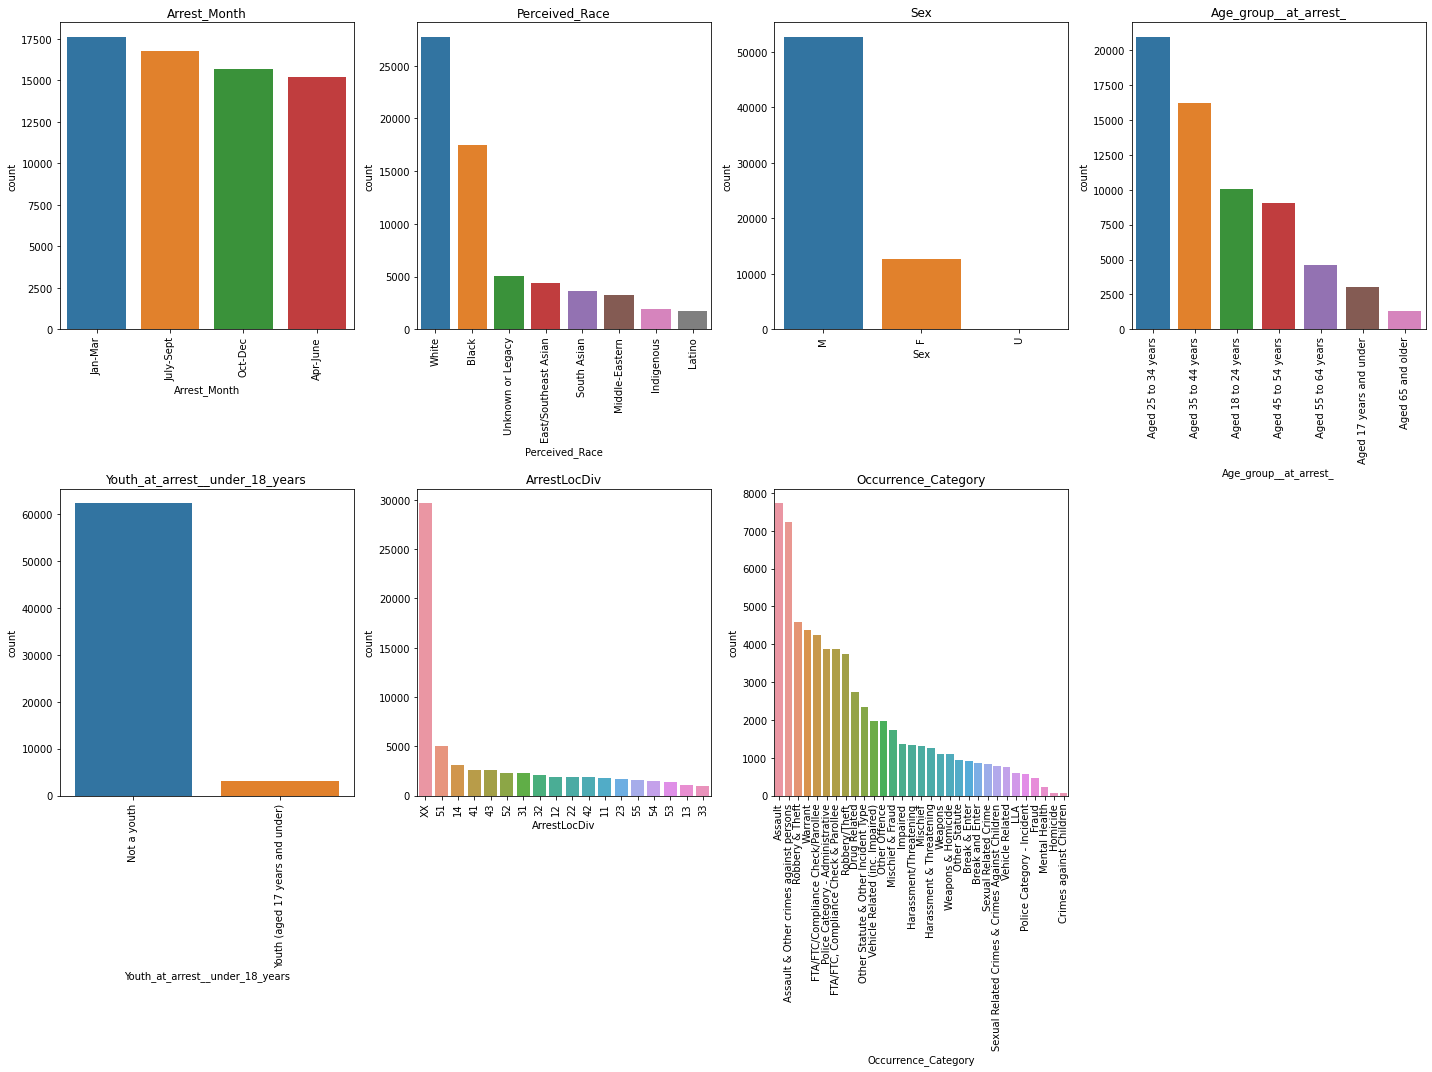

In [15]:
# creating a list of categorical variables
categorical_var = list(processed_df.select_dtypes("object"))

# visualizing the frequency of each class of a categorical variable
f = plt.figure(figsize=(20, 15))

# loop through the length of list of categorical variables and keep track of index
for n, var in enumerate(categorical_var):
    # add a new subplot iteratively
    ax = plt.subplot(2, 4, n + 1)

    count_df = processed_df.groupby(var).size().reset_index(name="count")
    count_df.sort_values(by="count", ascending=False, inplace=True)

    # plot subplot
    ax = sns.barplot(x=count_df[var], y=count_df['count'])

    # rotate ticks
    plt.xticks(rotation=90)

    # add subplot name
    plt.title(var)  

# adjust spacing of subplots
plt.tight_layout()

In [16]:
# aggregated count of each class in Arrest_Month
month_df = processed_df.groupby("Arrest_Month").size().reset_index(name="count")
month_df.sort_values(by="count", ascending=False, inplace=True)
month_df["relative_frequency"] = month_df["count"].apply(lambda x: (x/(month_df["count"].sum()))*100).round(1)
month_df

,Arrest_Month,count,relative_frequency
1,Jan-Mar,17613,27.0
2,July-Sept,16773,25.7
3,Oct-Dec,15705,24.1
0,Apr-June,15185,23.3


In [17]:
# aggregated count of each class in perceived race
count_race_df = processed_df.groupby("Perceived_Race").size().reset_index(name="count")
count_race_df.sort_values(by="count", ascending=False, inplace=True)
count_race_df["relative_frequency"] = count_race_df["count"].apply(lambda x: (x/(count_race_df["count"].sum()))*100).round(1)
count_race_df

,Perceived_Race,count,relative_frequency
7,White,27723,42.5
0,Black,17526,26.8
6,Unknown or Legacy,5060,7.8
1,East/Southeast Asian,4415,6.8
5,South Asian,3613,5.5
4,Middle-Eastern,3237,5.0
2,Indigenous,1934,3.0
3,Latino,1768,2.7


In [18]:
# aggregated count of each class in sex
count_sex_df = processed_df.groupby("Sex").size().reset_index(name="count")
count_sex_df.sort_values(by="count", ascending=False, inplace=True)
count_sex_df["relative_frequency"] = count_sex_df["count"].apply(lambda x: (x/(count_sex_df["count"].sum()))*100).round(1)
count_sex_df

,Sex,count,relative_frequency
1,M,52650,80.7
0,F,12617,19.3
2,U,9,0.0


In [19]:
# aggregated count of each class in Age_group__at_arrest_'
count_age_df = processed_df.groupby("Age_group__at_arrest_").size().reset_index(name="count")
count_age_df.sort_values(by="count", ascending=False, inplace=True)
count_age_df["relative_frequency"] = count_age_df["count"].apply(lambda x: (x/(count_age_df["count"].sum()))*100).round(1)
count_age_df

,Age_group__at_arrest_,count,relative_frequency
2,Aged 25 to 34 years,20949,32.1
3,Aged 35 to 44 years,16242,24.9
1,Aged 18 to 24 years,10041,15.4
4,Aged 45 to 54 years,9066,13.9
5,Aged 55 to 64 years,4590,7.0
0,Aged 17 years and under,3042,4.7
6,Aged 65 and older,1322,2.0


In [20]:
# aggregated count of each class in Youth at arrest'
count_youth_df = processed_df.groupby("Youth_at_arrest__under_18_years").size().reset_index(name="count")
count_youth_df.sort_values(by="count", ascending=False, inplace=True)
count_youth_df["relative_frequency"] = count_youth_df["count"].apply(lambda x: (x/(count_youth_df["count"].sum()))*100).round(1)
count_youth_df

,Youth_at_arrest__under_18_years,count,relative_frequency
0,Not a youth,62234,95.3
1,Youth (aged 17 years and under),3042,4.7


##### **Analysis of Independent Variable: Perceived Race**

In [21]:
# create race subset
perceived_race_df = processed_df.groupby(["PersonID","Perceived_Race", "Age_group__at_arrest_"]).agg({"PersonID":"count", "Booked":"sum", "StripSearch":"sum" })
perceived_race_df.rename(columns={"PersonID":"count_of_arrests"}, inplace=True)
perceived_race_df.reset_index(inplace=True)
perceived_race_df

,PersonID,Perceived_Race,Age_group__at_arrest_,count_of_arrests,Booked,StripSearch
0,300000,East/Southeast Asian,Aged 35 to 44 years,1,0,0
1,300001,White,Aged 17 years and under,1,1,0
2,300002,White,Aged 35 to 44 years,1,0,0
3,300003,White,Aged 25 to 34 years,6,5,1
4,300003,White,Aged 35 to 44 years,2,1,0
...,...,...,...,...,...,...
41126,337342,White,Aged 17 years and under,5,1,0
41127,337343,White,Aged 35 to 44 years,1,1,0
41128,337344,Black,Aged 18 to 24 years,1,1,1
41129,337345,Black,Aged 65 and older,1,0,0


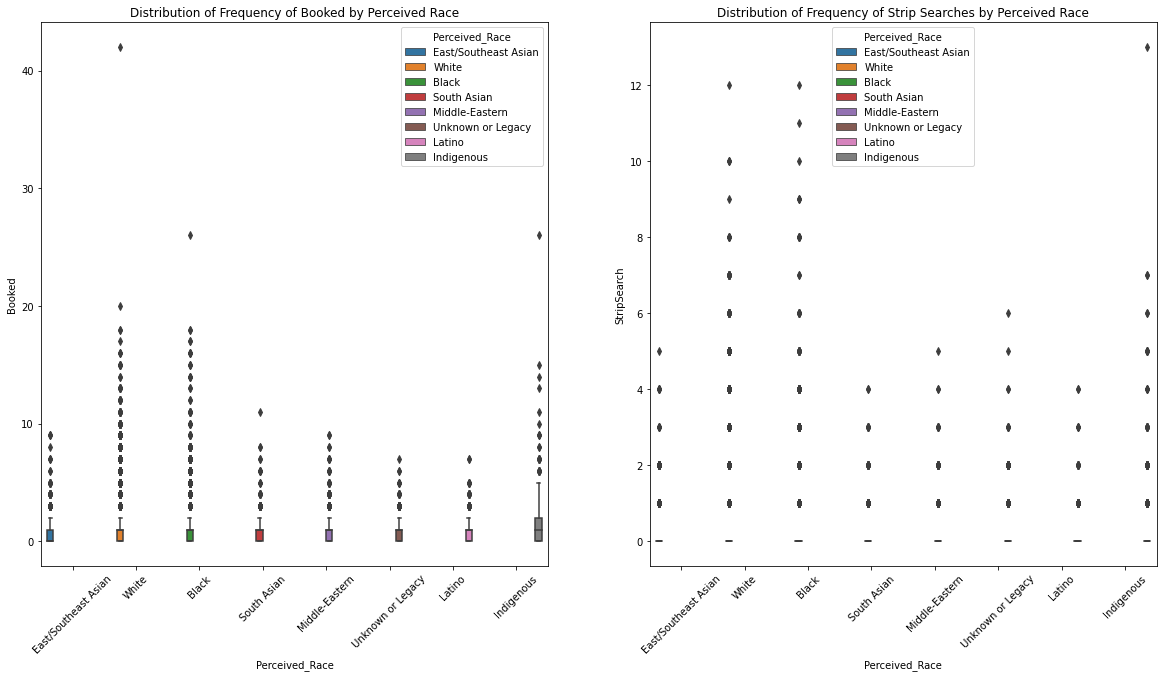

In [22]:
# distribution of the frequency of strip search and booked by sex
f, axes = plt.subplots(1, 2, figsize=(20, 10))

# distribution of booked by sex
sns.boxplot(data=perceived_race_df, x = "Perceived_Race", y = "Booked", hue="Perceived_Race", ax= axes[0])
axes[0].set_title("Distribution of Frequency of Booked by Perceived Race")
axes[0].tick_params(axis='x', labelrotation=45)

# distribution of strip search by sex
sns.boxplot(data=perceived_race_df, x = "Perceived_Race", y = "StripSearch", hue="Perceived_Race", ax= axes[1])
axes[1].set_title("Distribution of Frequency of Strip Searches by Perceived Race")
axes[1].tick_params(axis='x', labelrotation=45)

**Police Arrests by Age Group and Perceived Race**

In [23]:
# getting counts of arrests by age group and perceived race
race_age_df = perceived_race_df.groupby(["Perceived_Race", "Age_group__at_arrest_"]).agg({"count_of_arrests":"sum", "Booked":"sum", "StripSearch":"sum"}).reset_index()
race_age_df.sort_values(by="count_of_arrests", ascending=False, inplace=True)
race_age_df

,Perceived_Race,Age_group__at_arrest_,count_of_arrests,Booked,StripSearch
51,White,Aged 25 to 34 years,8291,4583,1280
52,White,Aged 35 to 44 years,7763,4305,1130
2,Black,Aged 25 to 34 years,6332,3693,889
53,White,Aged 45 to 54 years,4775,2509,520
1,Black,Aged 18 to 24 years,3791,2189,643
3,Black,Aged 35 to 44 years,3626,2045,473
50,White,Aged 18 to 24 years,2639,1348,332
54,White,Aged 55 to 64 years,2581,1204,228
44,Unknown or Legacy,Aged 25 to 34 years,1647,906,210
4,Black,Aged 45 to 54 years,1637,883,200


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Aged 25 to 34 years'),
  Text(1, 0, 'Aged 35 to 44 years'),
  Text(2, 0, 'Aged 45 to 54 years'),
  Text(3, 0, 'Aged 18 to 24 years'),
  Text(4, 0, 'Aged 55 to 64 years'),
  Text(5, 0, 'Aged 17 years and under'),
  Text(6, 0, 'Aged 65 and older')])

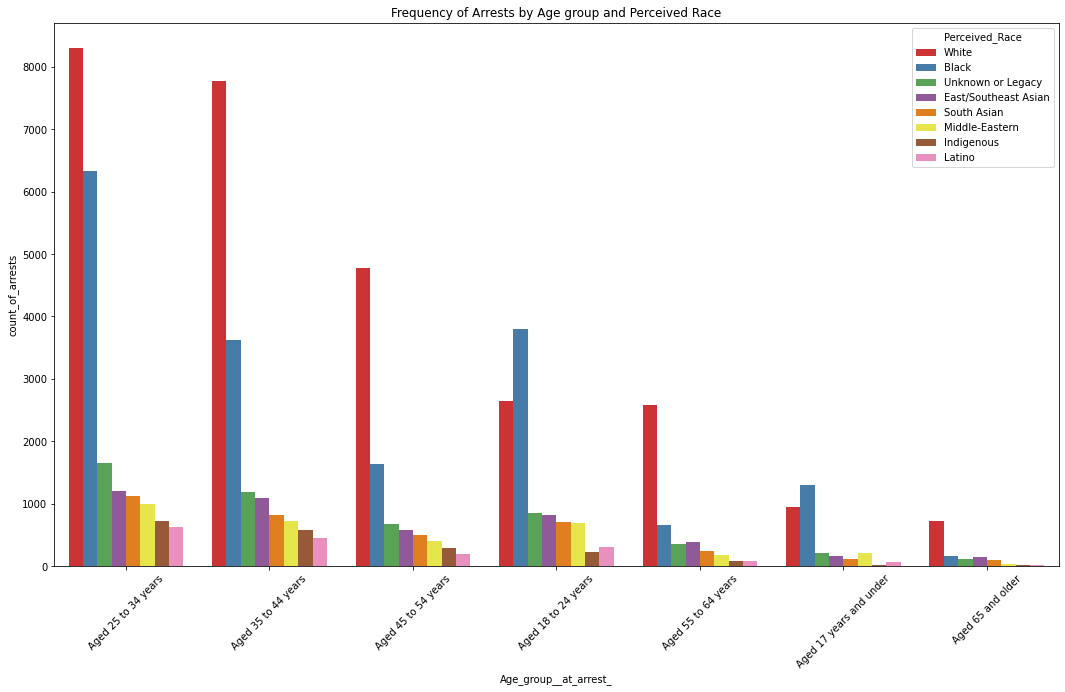

In [24]:
# visualize the frequency of arrests by age group and perceived race
f = plt.figure(figsize=(18, 10))
sns.barplot(data=race_age_df, x="Age_group__at_arrest_", y= "count_of_arrests", hue="Perceived_Race", palette="Set1")
plt.title("Frequency of Arrests by Age group and Perceived Race")
plt.xticks(rotation=45)

##### **Analysis of Control Variable: Sex**

In [25]:
# create sex subset
sex_subset_df = processed_df.groupby(["PersonID","Sex", "Age_group__at_arrest_"]).agg({"PersonID":"count", "Booked":"sum", "StripSearch":"sum" })
sex_subset_df.rename(columns={"PersonID":"count_of_arrests"}, inplace=True)
sex_subset_df.reset_index(inplace=True)
sex_subset_df

,PersonID,Sex,Age_group__at_arrest_,count_of_arrests,Booked,StripSearch
0,300000,M,Aged 35 to 44 years,1,0,0
1,300001,F,Aged 17 years and under,1,1,0
2,300002,M,Aged 35 to 44 years,1,0,0
3,300003,M,Aged 25 to 34 years,6,5,1
4,300003,M,Aged 35 to 44 years,2,1,0
...,...,...,...,...,...,...
38217,337342,M,Aged 17 years and under,5,1,0
38218,337343,M,Aged 35 to 44 years,1,1,0
38219,337344,M,Aged 18 to 24 years,1,1,1
38220,337345,M,Aged 65 and older,1,0,0


**Sex and Frequency of Booked and Strip Search**

Text(0.5, 1.0, 'Distribution of Frequency of Strip Searches by Sex')

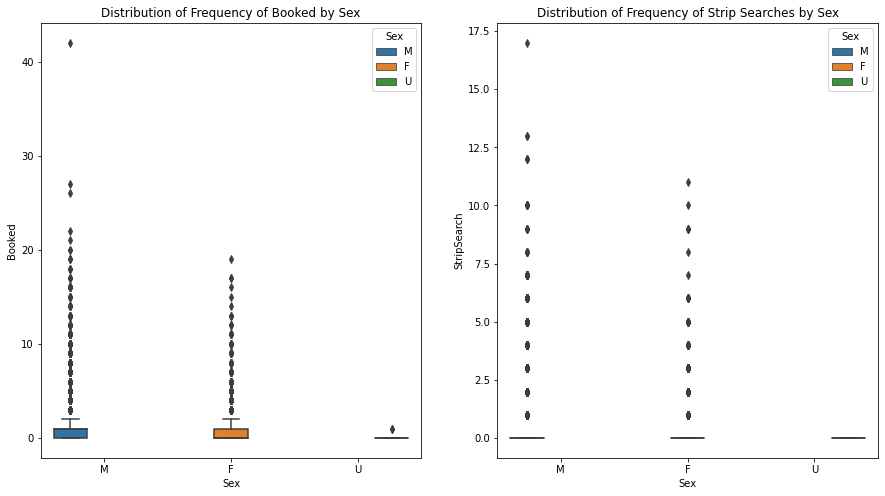

In [26]:
# distribution of the frequency of strip search and booked by sex
f, axes = plt.subplots(1, 2, figsize=(15, 8))

# distribution of booked by sex
sns.boxplot(data=sex_subset_df, x = "Sex", y = "Booked", hue="Sex", ax= axes[0])
axes[0].set_title("Distribution of Frequency of Booked by Sex")

# distribution of strip search by sex
sns.boxplot(data=sex_subset_df, x = "Sex", y = "StripSearch", hue="Sex", ax= axes[1])
axes[1].set_title("Distribution of Frequency of Strip Searches by Sex")

**Police Arrests by Age Group and Sex**

In [27]:
# group sex_df by sex and age
grouped_sex_df = sex_subset_df.groupby(["Sex", "Age_group__at_arrest_"]).agg({"count_of_arrests":"sum", "Booked":"sum", "StripSearch":"sum" }).reset_index()
grouped_sex_df.sort_values(by="count_of_arrests", ascending=False, inplace=True)
grouped_sex_df

,Sex,Age_group__at_arrest_,count_of_arrests,Booked,StripSearch
9,M,Aged 25 to 34 years,16714,9646,2249
10,M,Aged 35 to 44 years,13157,7449,1753
8,M,Aged 18 to 24 years,7970,4406,1134
11,M,Aged 45 to 54 years,7464,4014,770
2,F,Aged 25 to 34 years,4231,2039,522
12,M,Aged 55 to 64 years,3908,1910,331
3,F,Aged 35 to 44 years,3084,1430,345
7,M,Aged 17 years and under,2309,1027,249
1,F,Aged 18 to 24 years,2069,921,215
4,F,Aged 45 to 54 years,1602,687,135


Text(0.5, 1.0, 'Distribution of Police Arrests by Sex and Age Group')

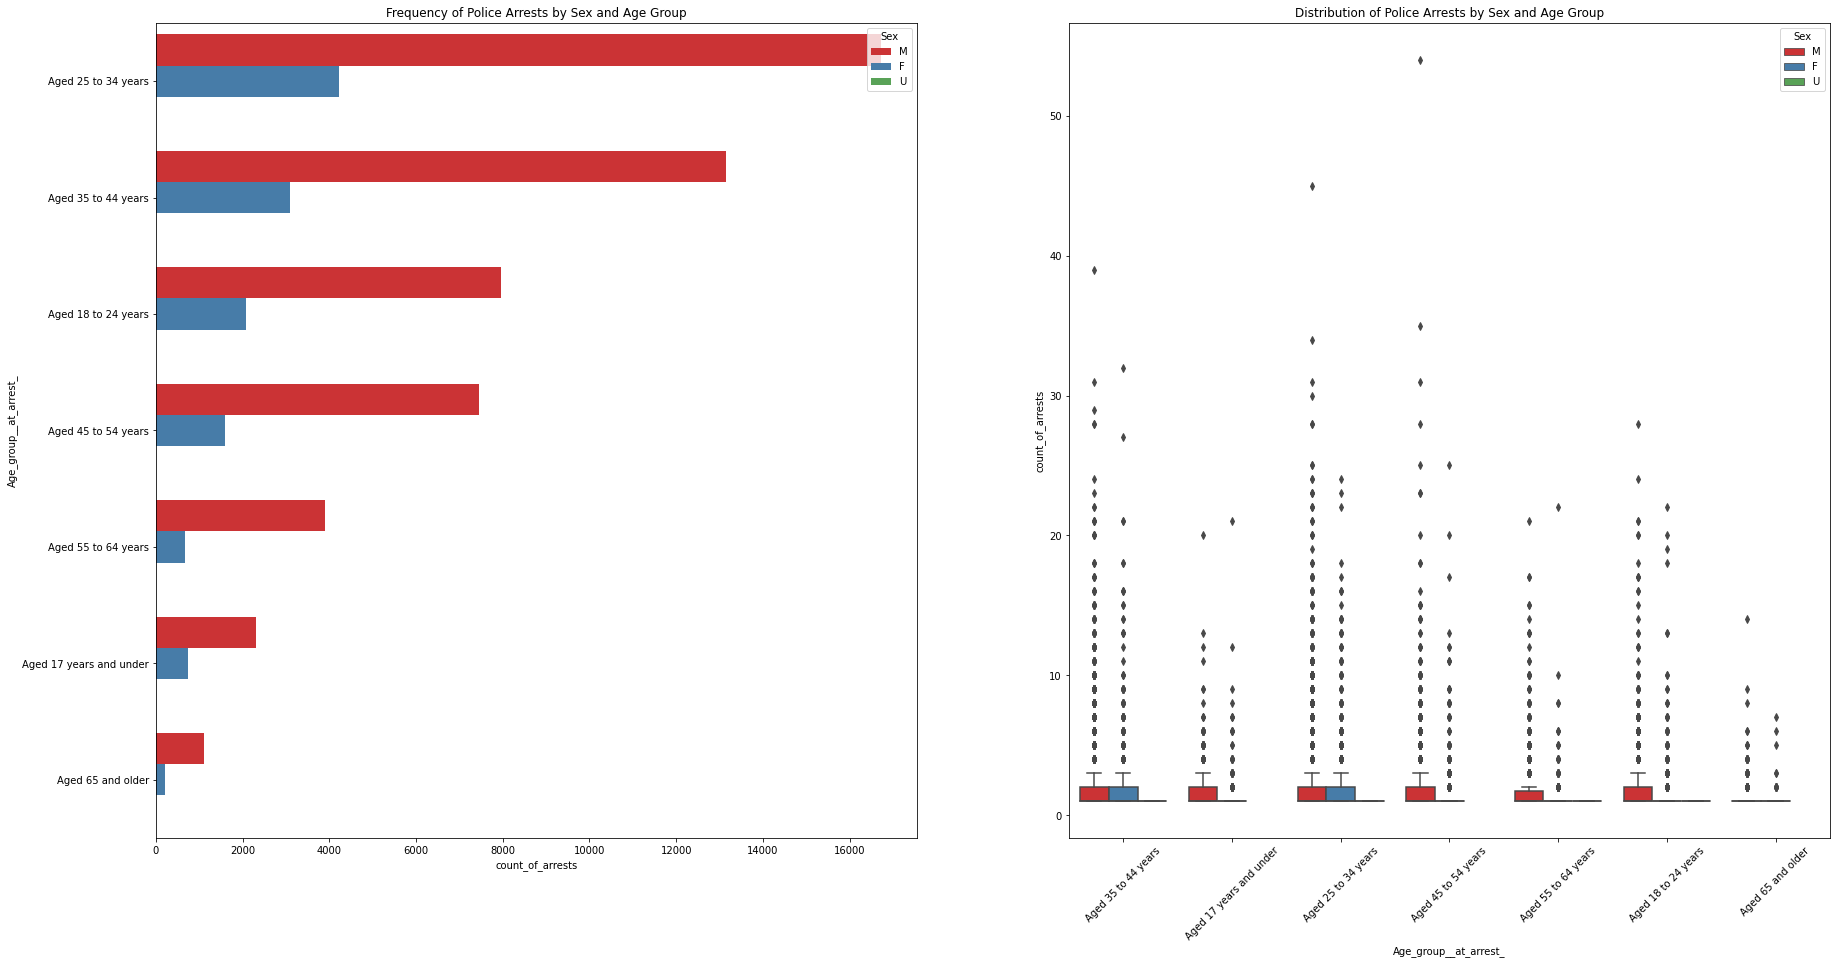

In [28]:
# visualize the distribution of female and male offenders by age group

f, axes = plt.subplots(1, 2, figsize=(30, 15))

# barplot of number of arrests by age group
sns.barplot(data=grouped_sex_df, y="Age_group__at_arrest_", x= "count_of_arrests", hue="Sex", palette="Set1", ax=axes[0])
axes[0].set_title("Frequency of Police Arrests by Sex and Age Group")

# boxplot of number of arrests by age group
sns.boxplot(data=sex_subset_df, x="Age_group__at_arrest_", y= "count_of_arrests", hue="Sex", palette="Set1", ax=axes[1])
plt.xticks(rotation=45)
axes[1].set_title("Distribution of Police Arrests by Sex and Age Group")

##### **Bivariate Analysis of Sex and Perceived Race**

In [29]:
# subset dataset by sex and perceived race on count of arrests
sex_race = processed_df.groupby(["PersonID", "Sex", "Perceived_Race"]).agg({"PersonID":"count", "Booked":"sum", "StripSearch":"sum"})
sex_race.rename(columns={"PersonID":"count_of_arrests"}, inplace=True)
sex_race.reset_index(inplace=True)
sex_race

,PersonID,Sex,Perceived_Race,count_of_arrests,Booked,StripSearch
0,300000,M,East/Southeast Asian,1,0,0
1,300001,F,White,1,1,0
2,300002,M,White,1,0,0
3,300003,M,White,8,6,1
4,300004,M,Black,1,1,0
...,...,...,...,...,...,...
40422,337342,M,White,5,1,0
40423,337343,M,White,1,1,0
40424,337344,M,Black,1,1,1
40425,337345,M,Black,1,0,0


Text(0.5, 1.0, 'Distribution of Arrests by Sex and Race')

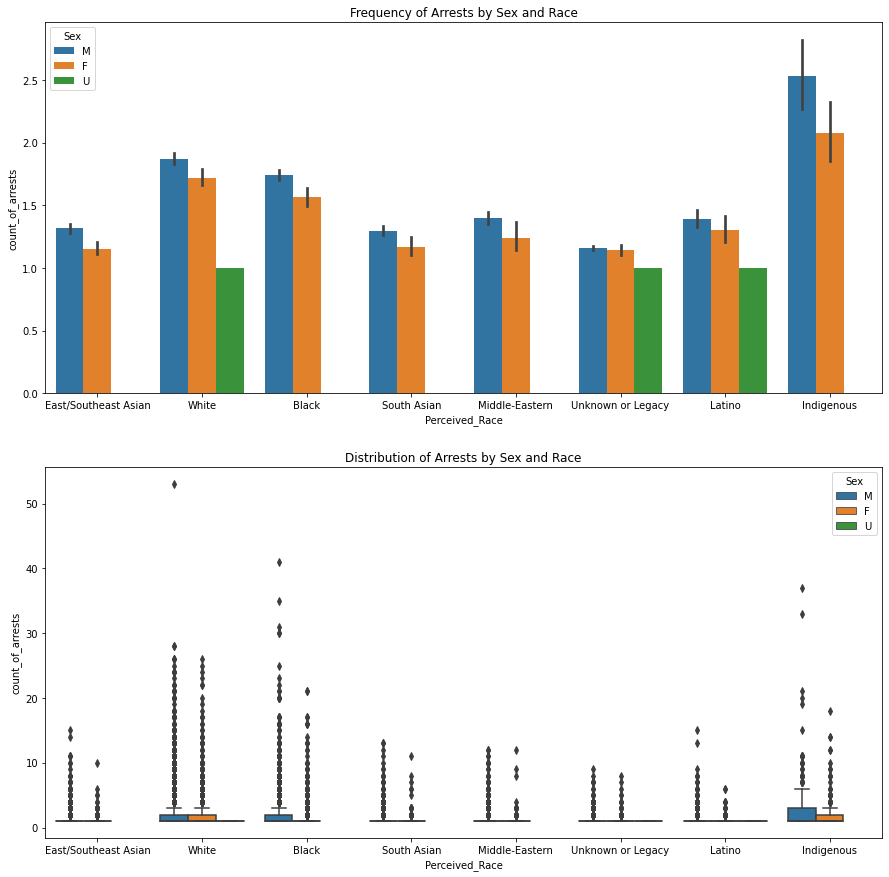

In [30]:
f, axes= plt.subplots(2, 1, figsize=(15, 15))

# frequency of arrests by sex and race
sns.barplot(data=sex_race, x = "Perceived_Race", y = "count_of_arrests", hue="Sex", ax= axes[0])
axes[0].set_title("Frequency of Arrests by Sex and Race")

# distribution of arrests by sex race
sns.boxplot(data=sex_race, x = "Perceived_Race", y = "count_of_arrests", hue="Sex", ax= axes[1])
axes[1].set_title("Distribution of Arrests by Sex and Race")

##### **Proportion of Arrests Leading to Strip Search or Booked by Race and Sex**

In [31]:
# proportion of arrests leading to booked and strips search by race
grouped_perceived_race_df = perceived_race_df.groupby("Perceived_Race").agg({"count_of_arrests":"sum", "Booked":"sum", "StripSearch":"sum"})

# compute total arrests
total_arrests = grouped_perceived_race_df["count_of_arrests"].sum()

# compute proportion of booked
def proportion_booked(row):
    total_arrests = row["count_of_arrests"]
    return (row["Booked"]/total_arrests)*100

# compute proportion of strip searches
def proportion_strip(row):
    total_arrests = row["count_of_arrests"]
    return (row["StripSearch"]/total_arrests)*100

grouped_perceived_race_df["Proportion of Arrests"] = grouped_perceived_race_df["count_of_arrests"].apply(lambda x: (x/total_arrests)*100).round(1)
grouped_perceived_race_df["Proportion of Booked"] = grouped_perceived_race_df.apply(proportion_booked, axis=1).round(1)
grouped_perceived_race_df["Proportion of Strip"] = grouped_perceived_race_df.apply(proportion_strip, axis=1).round(1)
grouped_perceived_race_df

,count_of_arrests,Booked,StripSearch,Proportion of Arrests,Proportion of Booked,Proportion of Strip
Perceived_Race,,,,,,
Black,17518,9833,2434,26.8,56.1,13.9
East/Southeast Asian,4412,2110,341,6.8,47.8,7.7
Indigenous,1932,1099,306,3.0,56.9,15.8
Latino,1768,974,132,2.7,55.1,7.5
Middle-Eastern,3237,1649,228,5.0,50.9,7.0
South Asian,3613,1789,257,5.5,49.5,7.1
Unknown or Legacy,5059,2491,537,7.8,49.2,10.6
White,27713,14532,3566,42.5,52.4,12.9


In [32]:
# proportion of arrests leading to booked and strips search by sex
grouped_perceived_sex_df = sex_subset_df.groupby("Sex").agg({"count_of_arrests":"sum", "Booked":"sum", "StripSearch":"sum"})

# compute total arrests
total_arrests = grouped_perceived_sex_df["count_of_arrests"].sum()


# compute proportion of booked
def proportion_booked(row):
    total_arrests = row["count_of_arrests"]
    return (row["Booked"]/total_arrests)*100

# compute proportion of strip searches
def proportion_strip(row):
    total_arrests = row["count_of_arrests"]
    return (row["StripSearch"]/total_arrests)*100

grouped_perceived_sex_df["Proportion of Arrests"] = grouped_perceived_sex_df["count_of_arrests"].apply(lambda x: (x/total_arrests)*100).round(1)
grouped_perceived_sex_df["Proportion of Booked"] = grouped_perceived_sex_df.apply(proportion_booked, axis=1).round(1)
grouped_perceived_sex_df["Proportion of Strip"] = grouped_perceived_sex_df.apply(proportion_strip, axis=1).round(1)
grouped_perceived_sex_df

,count_of_arrests,Booked,StripSearch,Proportion of Arrests,Proportion of Booked,Proportion of Strip
Sex,,,,,,
F,12609,5581,1283,19.3,44.3,10.2
M,52634,28894,6518,80.7,54.9,12.4
U,9,2,0,0.0,22.2,0.0


##### **Analysis of Encounter-Specific Variables by Perceived Race and Sex**

In [33]:
processed_df.columns

Index(['Arrest_Year', 'Arrest_Month', 'EventID', 'ArrestID', 'PersonID',
       'Perceived_Race', 'Sex', 'Age_group__at_arrest_',
       'Youth_at_arrest__under_18_years', 'ArrestLocDiv', 'StripSearch',
       'Booked', 'Occurrence_Category', 'Actions_at_arrest___Concealed_i',
       'Actions_at_arrest___Combative__', 'Actions_at_arrest___Resisted__d',
       'Actions_at_arrest___Mental_inst', 'Actions_at_arrest___Assaulted_o',
       'Actions_at_arrest___Cooperative', 'SearchReason_CauseInjury',
       'SearchReason_AssistEscape', 'SearchReason_PossessWeapons',
       'SearchReason_PossessEvidence', 'ItemsFound', 'ObjectId'],
      dtype='object')

In [34]:
# subset for encounter-specific variables by perceived race

race_encounter_df = processed_df[["Perceived_Race", 'Actions_at_arrest___Concealed_i',
       'Actions_at_arrest___Combative__', 'Actions_at_arrest___Resisted__d',
       'Actions_at_arrest___Mental_inst', 'Actions_at_arrest___Assaulted_o',
       'Actions_at_arrest___Cooperative']].copy()
race_encounter_df.head()

,Perceived_Race,Actions_at_arrest___Concealed_i,Actions_at_arrest___Combative__,Actions_at_arrest___Resisted__d,Actions_at_arrest___Mental_inst,Actions_at_arrest___Assaulted_o,Actions_at_arrest___Cooperative
0,White,0,0,0,0,0,1
1,White,0,0,0,0,0,0
2,Unknown or Legacy,0,0,0,0,0,0
3,Black,0,0,0,0,0,0
4,South Asian,0,0,0,0,0,0


In [35]:
# get total frequency of occurrence for each encounter-specific variable grouped by race
grouped_race_encounter_df = race_encounter_df.groupby(["Perceived_Race"]).agg("sum")
grouped_race_encounter_df

,Actions_at_arrest___Concealed_i,Actions_at_arrest___Combative__,Actions_at_arrest___Resisted__d,Actions_at_arrest___Mental_inst,Actions_at_arrest___Assaulted_o,Actions_at_arrest___Cooperative
Perceived_Race,,,,,,
Black,98,836,796,665,143,7466
East/Southeast Asian,15,123,117,106,10,2268
Indigenous,7,162,122,78,23,762
Latino,4,72,61,42,12,897
Middle-Eastern,13,122,103,110,16,1514
South Asian,12,126,90,82,14,1667
Unknown or Legacy,14,154,140,103,26,2220
White,103,1286,1073,993,171,12315


In [36]:
# relative frequency of action engaged by race

relative_freq_df = grouped_race_encounter_df.copy()
for column in relative_freq_df.columns[1:]:
    total = relative_freq_df[column].sum()
    relative_freq_df[column] = (relative_freq_df[column] / total)*100

relative_freq_df.round(1)

,Actions_at_arrest___Concealed_i,Actions_at_arrest___Combative__,Actions_at_arrest___Resisted__d,Actions_at_arrest___Mental_inst,Actions_at_arrest___Assaulted_o,Actions_at_arrest___Cooperative
Perceived_Race,,,,,,
Black,98,29.0,31.8,30.5,34.5,25.6
East/Southeast Asian,15,4.3,4.7,4.9,2.4,7.8
Indigenous,7,5.6,4.9,3.6,5.5,2.6
Latino,4,2.5,2.4,1.9,2.9,3.1
Middle-Eastern,13,4.2,4.1,5.0,3.9,5.2
South Asian,12,4.4,3.6,3.8,3.4,5.7
Unknown or Legacy,14,5.3,5.6,4.7,6.3,7.6
White,103,44.6,42.9,45.6,41.2,42.3


Text(0.5, 1.0, 'Breakdown of Actions Taken at Arrests by Perceived Race')

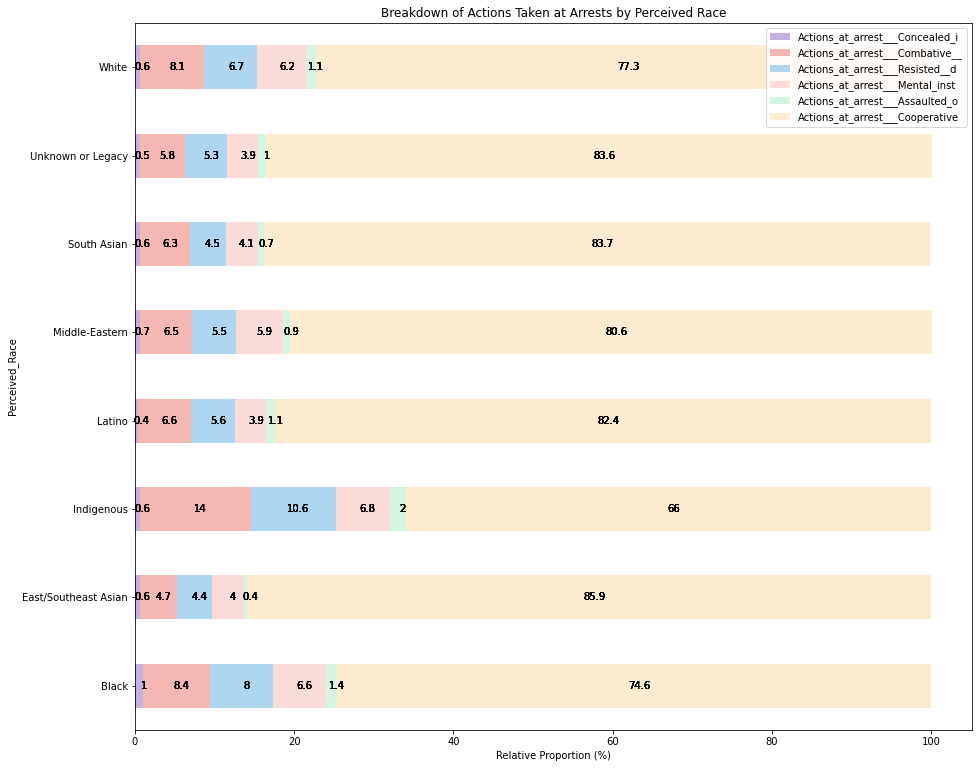

In [37]:
# visualizing the breakdown of actions encountered by law enforcement officiers by race

action_by_race = grouped_race_encounter_df.copy()
# action_by_race.set_index("Perceived_Race", inplace=True)

# compute sum of row
action_by_race["total"] = action_by_race.sum(axis=1)

# divide each value in a row by the total to get the relative proportion
action_by_race = action_by_race.apply(lambda x: (x / x['total'])*100, axis=1)
action_by_race.drop("total", axis=1, inplace=True)
action_by_race = action_by_race.round(1)
action_by_race

colors = ['#C3B1E1', '#F5B7B1', '#AED6F1', '#FADBD8', '#D5F5E3', '#FDEBD0']
ax = action_by_race.plot(kind="barh", stacked=True, figsize=(15,13), color=colors)

# add annotations to each bar
for i, (idx, row) in enumerate(action_by_race.iterrows()):
    for j, value in enumerate(row):
        ax.bar_label(ax.containers[j], label=f"{value:.1f}", 
                     label_type='center', fontsize=10, padding=5)
        
# add axis labels and title
ax.set_xlabel("Relative Proportion (%)")
ax.set_title("Breakdown of Actions Taken at Arrests by Perceived Race")

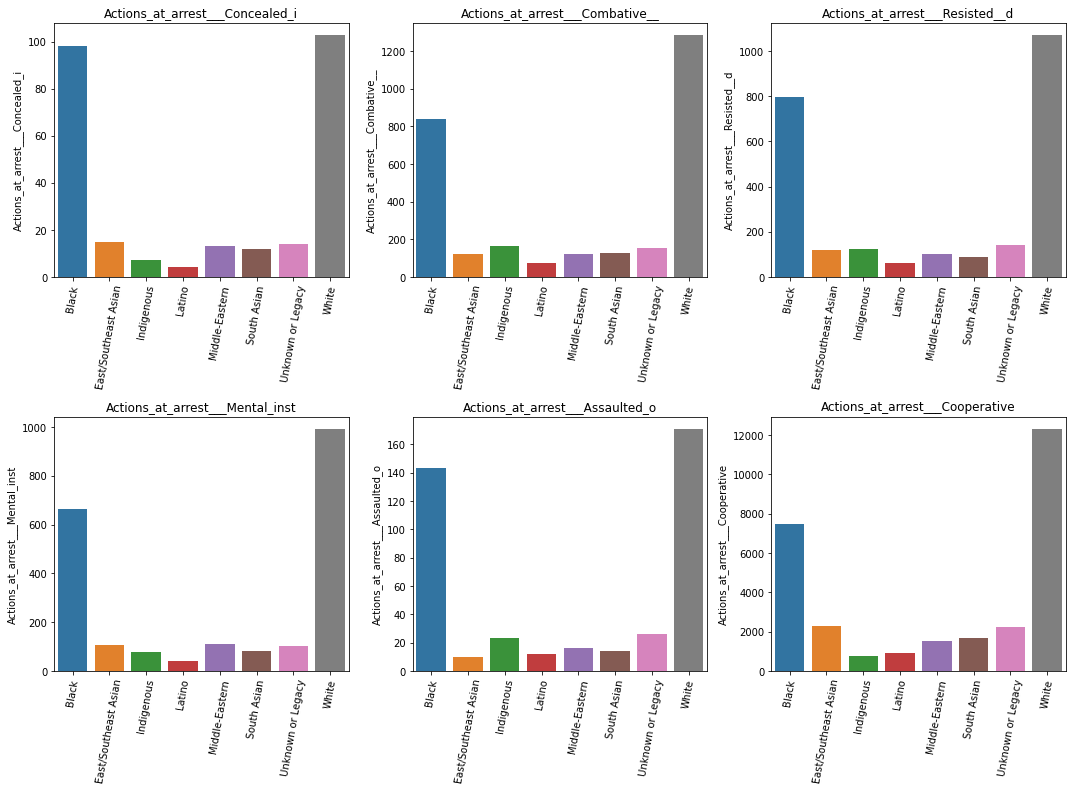

In [38]:
# visualize frequency of the type police-suspect interaction engaged at arrest by race
grouped_race_encounter_df.reset_index(inplace=True)

f = plt.figure(figsize=(15, 15))

encounter_vars = list(grouped_race_encounter_df.columns)[1:]

for n, var in enumerate(encounter_vars):
  ax = plt.subplot(3, 3, n+1)

  ax = sns.barplot(data = grouped_race_encounter_df, x = grouped_race_encounter_df["Perceived_Race"].unique(), y=var)

  plt.title(var)
  plt.xticks(rotation=80)

plt.tight_layout()

In [39]:
# subset for encounter-specific variables by sex

sex_encounter_df = processed_df[["Sex", 'Actions_at_arrest___Concealed_i',
       'Actions_at_arrest___Combative__', 'Actions_at_arrest___Resisted__d',
       'Actions_at_arrest___Mental_inst', 'Actions_at_arrest___Assaulted_o',
       'Actions_at_arrest___Cooperative']].copy()
sex_encounter_df.head()

,Sex,Actions_at_arrest___Concealed_i,Actions_at_arrest___Combative__,Actions_at_arrest___Resisted__d,Actions_at_arrest___Mental_inst,Actions_at_arrest___Assaulted_o,Actions_at_arrest___Cooperative
0,M,0,0,0,0,0,1
1,M,0,0,0,0,0,0
2,M,0,0,0,0,0,0
3,M,0,0,0,0,0,0
4,M,0,0,0,0,0,0


In [40]:
# get total frequency of occurrence for each encounter-specific variable grouped by sex
grouped_sex_encounter_df = sex_encounter_df.groupby(["Sex"]).agg("sum").reset_index()
grouped_sex_encounter_df

,Sex,Actions_at_arrest___Concealed_i,Actions_at_arrest___Combative__,Actions_at_arrest___Resisted__d,Actions_at_arrest___Mental_inst,Actions_at_arrest___Assaulted_o,Actions_at_arrest___Cooperative
0,F,21,563,433,505,105,5430
1,M,245,2317,2069,1672,310,23676
2,U,0,1,0,2,0,3


In [41]:
# get relative frequency of behaviour for each race 

relative_freq_sex_df = grouped_sex_encounter_df.copy()
for column in relative_freq_df.columns:
    total = relative_freq_sex_df[column].sum()
    relative_freq_sex_df[column] = (relative_freq_sex_df[column] / total)*100

relative_freq_sex_df.round(3)

,Sex,Actions_at_arrest___Concealed_i,Actions_at_arrest___Combative__,Actions_at_arrest___Resisted__d,Actions_at_arrest___Mental_inst,Actions_at_arrest___Assaulted_o,Actions_at_arrest___Cooperative
0,F,7.895,19.542,17.306,23.176,25.301,18.654
1,M,92.105,80.423,82.694,76.732,74.699,81.336
2,U,0.000,0.035,0.000,0.092,0.000,0.010


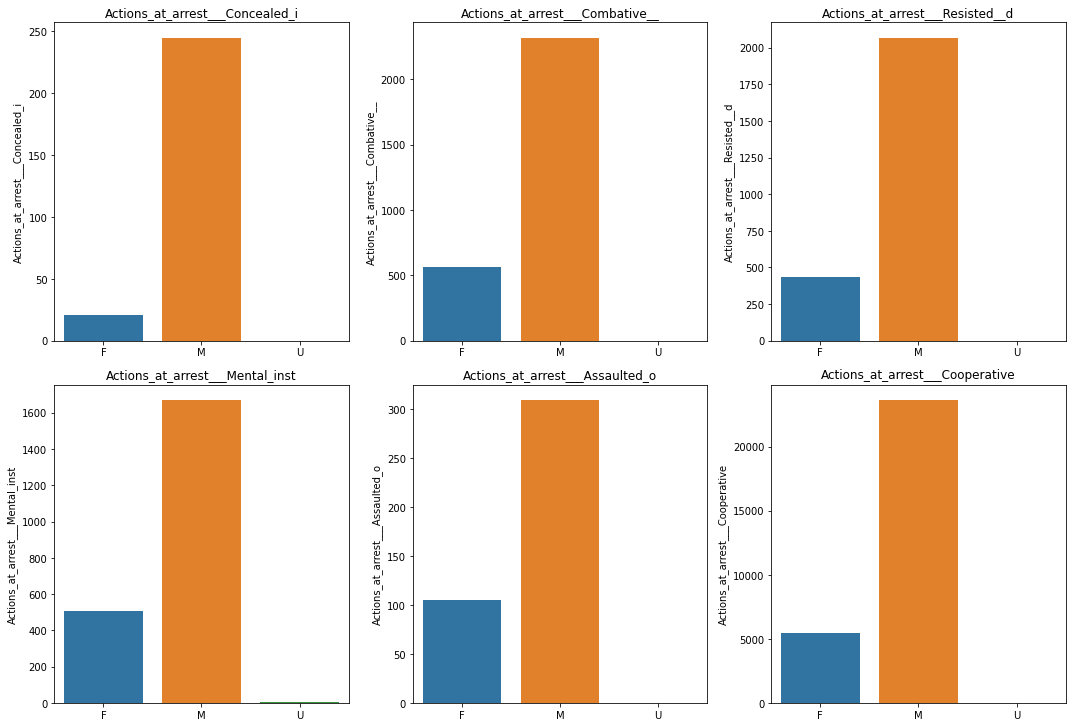

In [42]:
# visualize frequency of the type police-suspect interaction engaged at arrest by sex
f = plt.figure(figsize=(15, 15))

encounter_vars = list(grouped_sex_encounter_df.columns)[1:]

for n, var in enumerate(encounter_vars):
  ax = plt.subplot(3, 3, n+1)

  ax = sns.barplot(data = grouped_sex_encounter_df, x = grouped_sex_encounter_df["Sex"].unique(), y=var)

  plt.title(var)

plt.tight_layout()

##### **Number of Arrests by Year**

In [43]:
# view number of arrests by year
arrest_by_year = processed_df.groupby("Arrest_Year").size().reset_index(name="count")
arrest_by_year

,Arrest_Year,count
0,2020,31979
1,2021,33297


Text(0.5, 1.0, 'Number of Arrests (2020 vs 2021)')

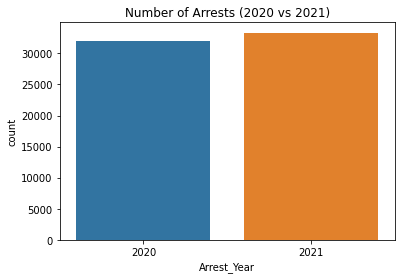

In [44]:
# plot number of arrests by year
sns.barplot(data=arrest_by_year, x = "Arrest_Year", y="count")
plt.title("Number of Arrests (2020 vs 2021)")

**Arrests by Perceived Race in 2020 vs 2021**

In [45]:
# Number of arrests by perceived race in 2020 vs 2021
race_arrest_year = processed_df.groupby(["Arrest_Year", "Perceived_Race"]).size().reset_index(name="Count")
race_arrest_year

,Arrest_Year,Perceived_Race,Count
0,2020,Black,8648
1,2020,East/Southeast Asian,2054
2,2020,Indigenous,999
3,2020,Latino,808
4,2020,Middle-Eastern,1507
5,2020,South Asian,1742
6,2020,Unknown or Legacy,2614
7,2020,White,13607
8,2021,Black,8878
9,2021,East/Southeast Asian,2361


In [46]:
# computing the total arrests for 2020 and 2021
total_arrests_2020 = np.sum(race_arrest_year[race_arrest_year["Arrest_Year"]==2020]["Count"])
total_arrests_2021 = np.sum(race_arrest_year[race_arrest_year["Arrest_Year"]==2021]["Count"])

In [47]:
# computing the relative frequency by year

def freq_arrest(row):
    if row["Arrest_Year"] == 2020:
        freq = (row["Count"]/total_arrests_2020)*100
    else:
        freq = (row["Count"]/total_arrests_2021)*100
    return freq.round(1)

race_arrest_year["proportion_by_year"] = race_arrest_year.apply(freq_arrest, axis=1)
race_arrest_year.sort_values(by=["Arrest_Year", "proportion_by_year"], ascending=[True, False], inplace=True)
race_arrest_year

,Arrest_Year,Perceived_Race,Count,proportion_by_year
7,2020,White,13607,42.5
0,2020,Black,8648,27.0
6,2020,Unknown or Legacy,2614,8.2
1,2020,East/Southeast Asian,2054,6.4
5,2020,South Asian,1742,5.4
4,2020,Middle-Eastern,1507,4.7
2,2020,Indigenous,999,3.1
3,2020,Latino,808,2.5
15,2021,White,14116,42.4
8,2021,Black,8878,26.7


Text(0.5, 1.0, 'Proportion of Arrests by Perceived Race in 2020 vs 2021')

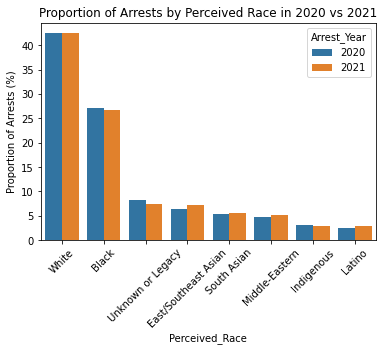

In [48]:
# visualizing number of arrests by perceived race in 2020 vs 2021
sns.barplot(data=race_arrest_year, x = "Perceived_Race", y="proportion_by_year", hue="Arrest_Year")
plt.xticks(rotation=45)
plt.ylabel("Proportion of Arrests (%)")
plt.title("Proportion of Arrests by Perceived Race in 2020 vs 2021")

**Partitioning the Data into 2020 and 2021**

In [49]:
# partition data by year 
arrests_2020 = processed_df[processed_df["Arrest_Year"]==2020]
arrests_2021 = processed_df[processed_df["Arrest_Year"]==2021]

In [50]:
# retrieve counts of arrests in 2020
race_arrests_2020 = arrests_2020.groupby(["PersonID", "Perceived_Race"]).agg({"PersonID":"count"})
race_arrests_2020.rename(columns={"PersonID":"count_of_arrests_2020"}, inplace=True)
race_arrests_2020.reset_index(inplace=True)
race_arrests_2020.shape

(22388, 3)

In [51]:
# retrieve counts of arrests in 2021
race_arrests_2021 = arrests_2021.groupby(["PersonID", "Perceived_Race"]).agg({"PersonID":"count"})
race_arrests_2021.rename(columns={"PersonID":"count_of_arrests_2021"}, inplace=True)
race_arrests_2021.reset_index(inplace=True)
race_arrests_2021.shape

(22861, 3)

In [52]:
# merge the 2020 arrest data with 2021 arrest data
merged_arrests = pd.merge(left = race_arrests_2021, right=race_arrests_2020, on=["PersonID", "Perceived_Race"], how="left").fillna(0)
merged_arrests["count_of_arrests_2020"] = merged_arrests["count_of_arrests_2020"].astype("int64")
merged_arrests

,PersonID,Perceived_Race,count_of_arrests_2021,count_of_arrests_2020
0,300003,White,4,4
1,300007,South Asian,4,4
2,300010,South Asian,1,0
3,300011,South Asian,1,0
4,300013,White,1,0
...,...,...,...,...
22856,337332,Unknown or Legacy,1,0
22857,337334,Latino,1,0
22858,337339,White,2,0
22859,337342,White,4,1


In [53]:
# checking for duplicate individuals (same personID with different perceived race)
merged_arrests["PersonID"].duplicated().any()

True

In [54]:
# drop duplicte individuals, keep first occurrence of periceved race
merged_arrests.drop_duplicates(subset=['PersonID'], keep='first', inplace=True)
merged_arrests.shape

(21614, 4)

#### **T-test: Arrests in 2020 vs 2021**

- H0: There is no significant difference in average number of police arrests in 2020 and 2021.

- HA: There is a significant difference in average number of police arrests in 2020 and 2021.

Assumptions Check:
- Since n>50 for each group, we can reasonably assume that it follows a normal distribution

In [55]:
arrests = processed_df.groupby(["Arrest_Year", "PersonID"]).agg({"PersonID":"count"})
arrests.rename(columns={"PersonID":"count_of_arrests"}, inplace=True)
arrests.reset_index(inplace=True)
arrests

,Arrest_Year,PersonID,count_of_arrests
0,2020,300000,1
1,2020,300001,1
2,2020,300002,1
3,2020,300003,4
4,2020,300004,1
...,...,...,...
42740,2021,337332,1
42741,2021,337334,1
42742,2021,337339,2
42743,2021,337342,4


Text(0.5, 1.0, 'Distribution of Number of Arrests by Arrest Year')

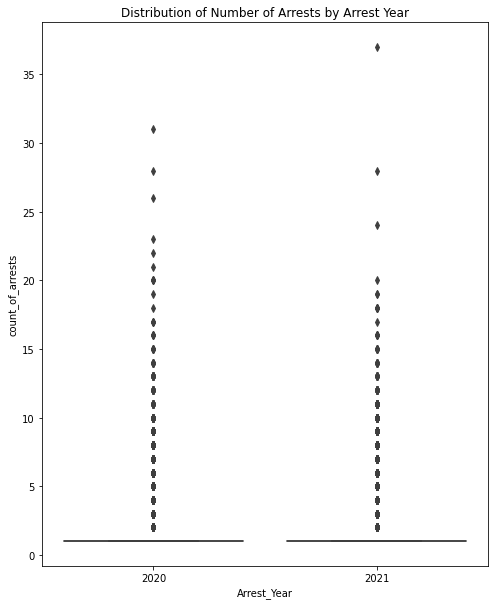

In [56]:
# box plot
plt.figure(figsize=(8, 10))
sns.boxplot(data=arrests, y = "count_of_arrests", x = "Arrest_Year")
plt.title("Distribution of Number of Arrests by Arrest Year")

In [57]:
# welch's T test for unequal variances
stats.ttest_ind(merged_arrests["count_of_arrests_2020"], merged_arrests["count_of_arrests_2021"], equal_var=False)

# At an alpha significance of 0.05, there is sufficient evidence to suggest that there is a difference in the average number of police arrests in 2020 and 2021.

Ttest_indResult(statistic=-84.07394089930877, pvalue=0.0)

#### **T-test: Arrests in 2020 vs 2021 Among the Black Population**

- H0: There is no significant difference in average number of police arrests in 2020 and 2021 among the black population.

- HA: There is a significant difference in average number of police arrests in 2020 and 2021 among the black population.

Assumptions Check:
- Since n>50 for each group, we can reasonably assume that it follows a normal distribution

In [58]:
arrests_black = processed_df[processed_df["Perceived_Race"]=="Black"].groupby(["Arrest_Year", "PersonID"]).agg({"PersonID":"count"})
arrests_black.rename(columns={"PersonID":"count_of_arrests"}, inplace=True)
arrests_black.reset_index(inplace=True)
arrests_black

,Arrest_Year,PersonID,count_of_arrests
0,2020,300004,1
1,2020,300008,1
2,2020,300024,2
3,2020,300029,1
4,2020,300036,1
...,...,...,...
11791,2021,337312,1
11792,2021,337328,3
11793,2021,337329,2
11794,2021,337330,1


Text(0.5, 1.0, 'Distribution of Number of Black Arrests by Arrest Year')

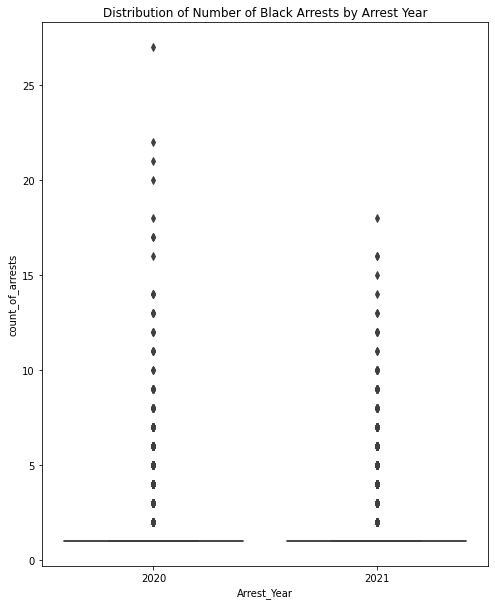

In [59]:
# box plot
plt.figure(figsize=(8, 10))
sns.boxplot(data=arrests_black, y = "count_of_arrests", x = "Arrest_Year")
plt.title("Distribution of Number of Black Arrests by Arrest Year")

In [60]:
# homogeneity of variance assumption check

# get list of unique classes in a categorical variable
groups = arrests_black["Arrest_Year"].unique()

# create list of df subsets
subgroups = [arrests_black[arrests_black['Arrest_Year'] == group]['count_of_arrests'] for group in groups]
statistic, p = stats.levene(*subgroups, center="mean")
# center is optional, but set to median by desult

print(f'Statistic: {statistic:.3f}, p-value: {p:.3f}')

Statistic: 1.936, p-value: 0.164


In [61]:
# welch's T test for unequal variances
black_arrests = merged_arrests[merged_arrests["Perceived_Race"]=="Black"]

stats.ttest_ind(black_arrests["count_of_arrests_2021"], black_arrests["count_of_arrests_2020"], equal_var=True, alternative="greater")

# At an alpha significance of 0.05, there is sufficient evidence to suggest that there is a difference in the average number of police arrests in 2020 and 2021 among the black population.

Ttest_indResult(statistic=39.03772839462505, pvalue=0.0)

#### **T-test: Arrests in 2020 vs 2021 Among the Indigenous Population**

- H0: There is no significant difference in average number of police arrests in 2020 and 2021 among the indigenous population.

- HA: There is a significant difference in average number of police arrests in 2020 and 2021 among the indigenous population.

Assumptions Check:
- Since n>50 for each group, we can reasonably assume that it follows a normal distribution

In [62]:
arrests_indigenous = processed_df[processed_df["Perceived_Race"]=="Indigenous"].groupby(["Arrest_Year", "PersonID"]).agg({"PersonID":"count"})
arrests_indigenous.rename(columns={"PersonID":"count_of_arrests"}, inplace=True)
arrests_indigenous.reset_index(inplace=True)
arrests_indigenous

,Arrest_Year,PersonID,count_of_arrests
0,2020,300028,1
1,2020,300101,1
2,2020,300117,2
3,2020,300190,1
4,2020,300206,1
...,...,...,...
999,2021,336774,2
1000,2021,336841,1
1001,2021,336891,5
1002,2021,336921,1


Text(0.5, 1.0, 'Distribution of Number of Indigenous Arrests by Arrest Year')

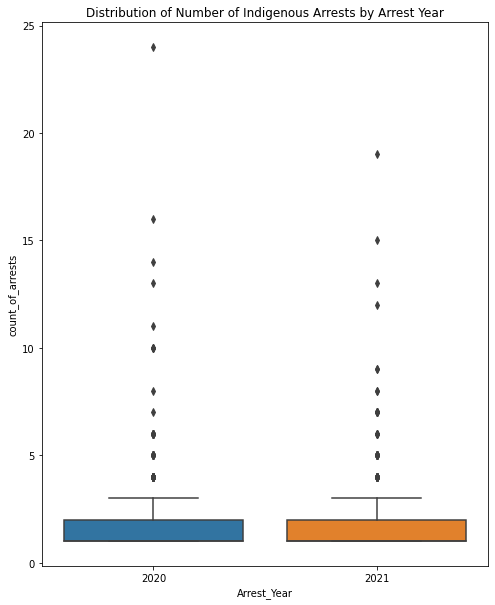

In [63]:
# box plot
plt.figure(figsize=(8, 10))
sns.boxplot(data=arrests_indigenous, y = "count_of_arrests", x = "Arrest_Year")
plt.title("Distribution of Number of Indigenous Arrests by Arrest Year")

In [64]:
# homogeneity of variance assumption check

# get list of unique classes in a categorical variable
groups = arrests_indigenous["Arrest_Year"].unique()

# create list of df subsets
subgroups = [arrests_indigenous[arrests_indigenous['Arrest_Year'] == group]['count_of_arrests'] for group in groups]
statistic, p = stats.levene(*subgroups, center="mean")
# center is optional, but set to median by desult

print(f'Statistic: {statistic:.3f}, p-value: {p:.3f}')

Statistic: 0.008, p-value: 0.931


In [65]:
# welch's T test for unequal variances
indigenous_arrests = merged_arrests[merged_arrests["Perceived_Race"]=="Indigenous"]

stats.ttest_ind(indigenous_arrests["count_of_arrests_2021"], indigenous_arrests["count_of_arrests_2020"], equal_var=True, alternative="greater")

# At an alpha significance of 0.05, there is sufficient evidence to suggest that there is a difference in the average number of police arrests in 2020 and 2021 among the indigenous population.

Ttest_indResult(statistic=6.848120480547407, pvalue=6.81833942174122e-12)

#### **T-tests for behaviour**

T-test: Arrests of whether concealing items or not

H0: There is no significant difference in the average number of police arrests between suspects concealing items or not.

HA: There is a significant difference in the average number of police arrests between suspects concealing items or not.

Assumptions Check:

Since n>50 for each group, we can reasonably assume that it follows a normal distribution.

In [66]:
arrests_concealed = processed_df.groupby(["PersonID"]).agg({"PersonID":"count",'Actions_at_arrest___Concealed_i':"sum"})
arrests_concealed.rename(columns={"PersonID":"count_of_arrests"}, inplace=True)
arrests_concealed.reset_index(inplace=True)
arrests_concealed["whether_Concealed"] = arrests_concealed.apply(lambda x: "N" if x.Actions_at_arrest___Concealed_i== 0 else "Y", axis=1)
arrests_concealed.drop('Actions_at_arrest___Concealed_i',axis=1, inplace=True)
arrests_concealed

,PersonID,count_of_arrests,whether_Concealed
0,300000,1,N
1,300001,1,N
2,300002,1,N
3,300003,8,N
4,300004,1,N
...,...,...,...
37342,337342,5,N
37343,337343,1,N
37344,337344,1,N
37345,337345,1,N


Text(0.5, 1.0, 'Distribution of Number of Arrests by whether Concealing or Not')

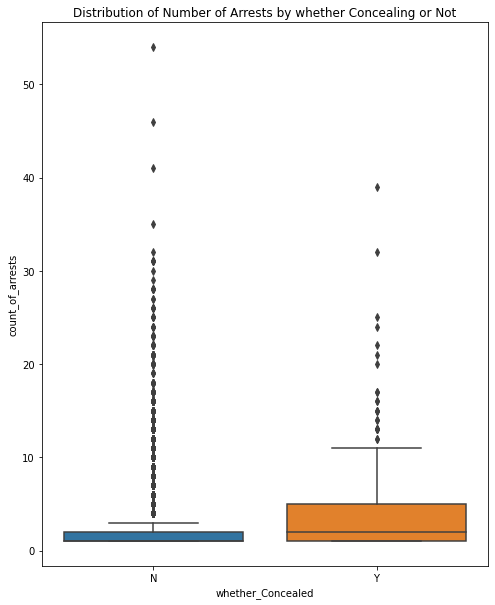

In [67]:
# box plot
plt.figure(figsize=(8, 10))
sns.boxplot(data=arrests_concealed, y = "count_of_arrests", x = "whether_Concealed")
plt.title("Distribution of Number of Arrests by whether Concealing or Not")

In [68]:
# check variance consistency
group_n_con = arrests_concealed.loc[arrests_concealed.loc[:,'whether_Concealed']=='N']['count_of_arrests']
group_y_con = arrests_concealed.loc[arrests_concealed.loc[:,'whether_Concealed']=='Y']['count_of_arrests']
statistic, p = stats.levene(group_n_con, group_y_con, center='mean')
print(f'Statistic: {statistic:.3f}, p-value: {p:.3f}')
# with p-value smaller than 0.05, the variances of two groups are inconsistent, so we apply welch's T test for unequal variances.

Statistic: 541.831, p-value: 0.000


In [69]:
# welch's T test for unequal variances
stats.ttest_ind(group_y_con, group_n_con, equal_var=False)

# At an alpha significance of 0.05, there is sufficient evidence to suggest that there is a difference in the average number of police arrests between suspects concealing items or not.

Ttest_indResult(statistic=7.766648687843738, pvalue=1.8142034798492944e-13)

#### **T-test: Arrests of combative, violent or spitter/biter behaviour**

H0: There is no significant difference in the average number of police arrests between suspects whether performing combative, violent or spitter/biter behaviour or not. 

HA: There is a significant difference in the average number of police arrests between suspects whether performing combative, violent or spitter/biter behaviour or not. 

Assumptions Check:

Since n>50 for each group, we can reasonably assume that it follows a normal distribution.

In [70]:
arrests_combative = processed_df.groupby(["PersonID"]).agg({"PersonID":"count",'Actions_at_arrest___Combative__':"sum"})
arrests_combative.rename(columns={"PersonID":"count_of_arrests"}, inplace=True)
arrests_combative.reset_index(inplace=True)
arrests_combative["whether_Combative"] = arrests_combative.apply(lambda x: "N" if x.Actions_at_arrest___Combative__== 0 else "Y", axis=1)
arrests_combative.drop('Actions_at_arrest___Combative__',axis=1, inplace=True)
arrests_combative

,PersonID,count_of_arrests,whether_Combative
0,300000,1,N
1,300001,1,N
2,300002,1,N
3,300003,8,N
4,300004,1,N
...,...,...,...
37342,337342,5,N
37343,337343,1,N
37344,337344,1,N
37345,337345,1,N


Text(0.5, 1.0, 'Distribution of Number of Arrests by whether Performing Combatively or Not')

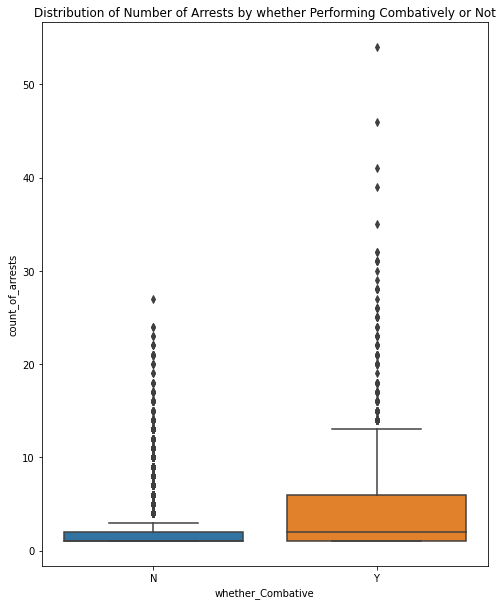

In [71]:
plt.figure(figsize=(8, 10))
sns.boxplot(data=arrests_combative, y = "count_of_arrests", x = "whether_Combative")
plt.title("Distribution of Number of Arrests by whether Performing Combatively or Not")

In [72]:
# check variance consistency
group_n_com = arrests_combative.loc[arrests_combative.loc[:,'whether_Combative']=='N']['count_of_arrests']
group_y_com = arrests_combative.loc[arrests_combative.loc[:,'whether_Combative']=='Y']['count_of_arrests']
statistic, p = stats.levene(group_n_com, group_y_com, center='mean')
print(f'Statistic: {statistic:.3f}, p-value: {p:.3f}')
# with p-value smaller than 0.05, the variances of two groups are inconsistent, so we apply welch's T test for unequal variances.

Statistic: 6226.413, p-value: 0.000


In [73]:
# welch's T test for unequal variances
stats.ttest_ind(group_y_com, group_n_com, equal_var=False)

# At an alpha significance of 0.05, there is sufficient evidence to suggest that there is a difference in the average number of police arrests between suspects whether performing combatively or not.

Ttest_indResult(statistic=26.703587663440167, pvalue=2.472074592690467e-137)

#### **T-test: Arrests of suspects who resisted, defensive or escape risk**

H0: There is no significant difference in the average number of police arrests between suspects who resisted, indicated defensive and escaping risk or not. 

HA: There is a significant difference in the average number of police arrests between suspects who resisted, indicated defensive and escaping risk or not. 

Assumptions Check:

Since n>50 for each group, we can reasonably assume that it follows a normal distribution.

In [74]:
arrests_resisted = processed_df.groupby(["PersonID"]).agg({"PersonID":"count",'Actions_at_arrest___Resisted__d':"sum"})
arrests_resisted.rename(columns={"PersonID":"count_of_arrests"}, inplace=True)
arrests_resisted.reset_index(inplace=True)
arrests_resisted["whether_Resisted"] = arrests_resisted.apply(lambda x: "N" if x.Actions_at_arrest___Resisted__d== 0 else "Y", axis=1)
arrests_resisted.drop('Actions_at_arrest___Resisted__d',axis=1, inplace=True)
arrests_resisted

,PersonID,count_of_arrests,whether_Resisted
0,300000,1,N
1,300001,1,N
2,300002,1,N
3,300003,8,N
4,300004,1,N
...,...,...,...
37342,337342,5,Y
37343,337343,1,N
37344,337344,1,N
37345,337345,1,N


Text(0.5, 1.0, 'Distribution of Number of Arrests by whether Resisted or Not')

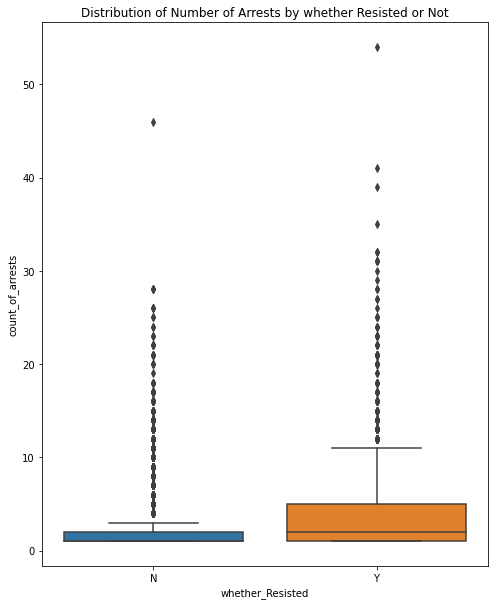

In [75]:
plt.figure(figsize=(8, 10))
sns.boxplot(data=arrests_resisted, y = "count_of_arrests", x = "whether_Resisted")
plt.title("Distribution of Number of Arrests by whether Resisted or Not")

In [76]:
# check variance consistency
group_n_resisted = arrests_resisted.loc[arrests_resisted.loc[:,'whether_Resisted']=='N']['count_of_arrests']
group_y_resisted = arrests_resisted.loc[arrests_resisted.loc[:,'whether_Resisted']=='Y']['count_of_arrests']
statistic, p = stats.levene(group_n_resisted, group_y_resisted, center='mean')
print(f'Statistic: {statistic:.3f}, p-value: {p:.3f}')
# with p-value smaller than 0.05, the variances of two groups are inconsistent, so we apply welch's T test for unequal variances.

Statistic: 5343.500, p-value: 0.000


In [77]:
# welch's T test for unequal variances
stats.ttest_ind(group_y_resisted, group_n_resisted, equal_var=False)

# At an alpha significance of 0.05, there is sufficient evidence to suggest that there is a difference in the average number of police arrests between suspects whether resisted or not.

Ttest_indResult(statistic=24.724014434045216, pvalue=5.76360291151285e-119)

#### **T-test: Arrests of suspects with mental instability or suicidal tendencies.**

H0: There is no significant difference in the average number of police arrests between suspects who have mental instability or suicidal tendencies or not. 

HA: There is a significant difference in the average number of police arrests between suspects who have mental instability or suicidal tendencies or not. 

Assumptions Check:

Since n>50 for each group, we can reasonably assume that it follows a normal distribution.

In [78]:
arrests_mental = processed_df.groupby(["PersonID"]).agg({"PersonID":"count",'Actions_at_arrest___Mental_inst':"sum"})
arrests_mental.rename(columns={"PersonID":"count_of_arrests"}, inplace=True)
arrests_mental.reset_index(inplace=True)
arrests_mental["whether_Mental_Instable"] = arrests_mental.apply(lambda x: "N" if x.Actions_at_arrest___Mental_inst== 0 else "Y", axis=1)
arrests_mental.drop('Actions_at_arrest___Mental_inst',axis=1, inplace=True)
arrests_mental

,PersonID,count_of_arrests,whether_Mental_Instable
0,300000,1,N
1,300001,1,N
2,300002,1,N
3,300003,8,Y
4,300004,1,N
...,...,...,...
37342,337342,5,N
37343,337343,1,N
37344,337344,1,N
37345,337345,1,N


Text(0.5, 1.0, 'Distribution of Number of Arrests by whether Suffered Mental Instability or Not')

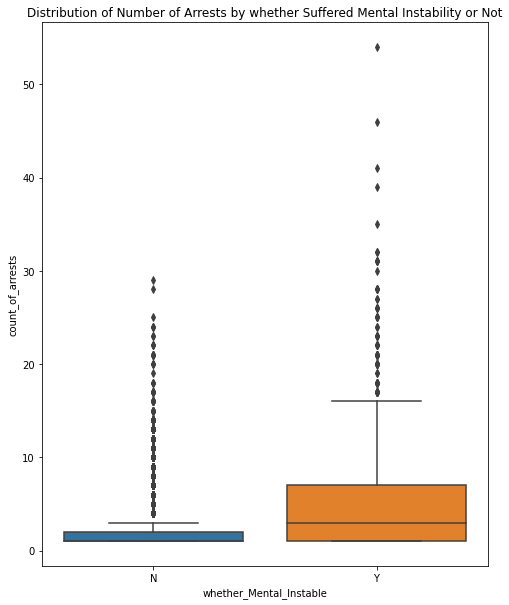

In [79]:
plt.figure(figsize=(8, 10))
sns.boxplot(data=arrests_mental, y = "count_of_arrests", x = "whether_Mental_Instable")
plt.title("Distribution of Number of Arrests by whether Suffered Mental Instability or Not")

In [80]:
# check variance consistency
group_n_instable_mental = arrests_mental.loc[arrests_mental.loc[:,'whether_Mental_Instable']=='N']['count_of_arrests']
group_y_instable_mental = arrests_mental.loc[arrests_mental.loc[:,'whether_Mental_Instable']=='Y']['count_of_arrests']
statistic, p = stats.levene(group_n_instable_mental, group_y_instable_mental, center='mean')
print(f'Statistic: {statistic:.3f}, p-value: {p:.3f}')
# with p-value smaller than 0.05, the variances of two groups are inconsistent, so we apply welch's T test for unequal variances.

Statistic: 6360.450, p-value: 0.000


In [81]:
# welch's T test for unequal variances
stats.ttest_ind(group_y_instable_mental, group_n_instable_mental, equal_var=False)

# At an alpha significance of 0.05, there is sufficient evidence to suggest that there is a difference in the average number of police arrests between suspects whether having mental instability or not.

Ttest_indResult(statistic=25.983931350231163, pvalue=3.3117720352785236e-125)

#### **T-test: Arrests of suspects assaulting officers.**

H0: There is no significant difference in the average number of police arrests between suspects who assaulted officers or not. 

HA: There is a significant difference in the average number of police arrests between suspects who assaulted officers or not.

Assumptions Check:

Since n>50 for each group, we can reasonably assume that it follows a normal distribution.

In [82]:
arrests_assaulted = processed_df.groupby(["PersonID"]).agg({"PersonID":"count",'Actions_at_arrest___Assaulted_o':"sum"})
arrests_assaulted.rename(columns={"PersonID":"count_of_arrests"}, inplace=True)
arrests_assaulted.reset_index(inplace=True)
arrests_assaulted["whether_Assaulted_officers"] = arrests_assaulted.apply(lambda x: "N" if x.Actions_at_arrest___Assaulted_o == 0 else "Y", axis=1)
arrests_assaulted.drop('Actions_at_arrest___Assaulted_o',axis=1, inplace=True)
arrests_assaulted

,PersonID,count_of_arrests,whether_Assaulted_officers
0,300000,1,N
1,300001,1,N
2,300002,1,N
3,300003,8,N
4,300004,1,N
...,...,...,...
37342,337342,5,N
37343,337343,1,N
37344,337344,1,N
37345,337345,1,N


Text(0.5, 1.0, 'Distribution of Number of Arrests by whether Assaulted Officers or Not')

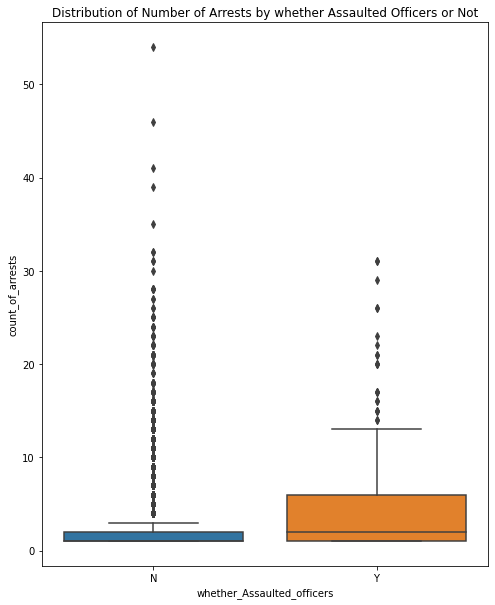

In [83]:
plt.figure(figsize=(8, 10))
sns.boxplot(data=arrests_assaulted, y = "count_of_arrests", x = "whether_Assaulted_officers")
plt.title("Distribution of Number of Arrests by whether Assaulted Officers or Not")

In [84]:
# check variance consistency
group_n_assaulted = arrests_assaulted.loc[arrests_assaulted.loc[:,'whether_Assaulted_officers']=='N']['count_of_arrests']
group_y_assaulted = arrests_assaulted.loc[arrests_assaulted.loc[:,'whether_Assaulted_officers']=='Y']['count_of_arrests']
statistic, p = stats.levene(group_n_assaulted, group_y_assaulted, center='mean')
print(f'Statistic: {statistic:.3f}, p-value: {p:.3f}')
# with p-value smaller than 0.05, the variances of two groups are inconsistent, so we apply welch's T test for unequal variances.

Statistic: 768.347, p-value: 0.000


In [85]:
# welch's T test for unequal variances
stats.ttest_ind(group_y_assaulted, group_n_assaulted, equal_var=False)

# At an alpha significance of 0.05, there is sufficient evidence to suggest that there is a difference in the average number of police arrests between suspects whether assaulted officers or not.

Ttest_indResult(statistic=10.419484786284066, pvalue=1.5968798569813198e-22)

#### **T-test: Arrests of suspects cooperating.**

H0: There is no significant difference in the average number of police arrests between suspects who cooperated or not. 

HA: There is a significant difference in the average number of police arrests between suspects who cooperated or not. 

Assumptions Check:

Since n>50 for each group, we can reasonably assume that it follows a normal distribution.

In [86]:
arrests_cooperative = processed_df.groupby(["PersonID"]).agg({"PersonID":"count",'Actions_at_arrest___Cooperative':"sum"})
arrests_cooperative.rename(columns={"PersonID":"count_of_arrests"}, inplace=True)
arrests_cooperative.reset_index(inplace=True)
arrests_cooperative["whether_Cooperative"] = arrests_cooperative.apply(lambda x: "N" if x.Actions_at_arrest___Cooperative == 0 else "Y", axis=1)
arrests_cooperative.drop('Actions_at_arrest___Cooperative',axis=1, inplace=True)
arrests_cooperative

,PersonID,count_of_arrests,whether_Cooperative
0,300000,1,N
1,300001,1,N
2,300002,1,Y
3,300003,8,Y
4,300004,1,Y
...,...,...,...
37342,337342,5,Y
37343,337343,1,Y
37344,337344,1,N
37345,337345,1,Y


Text(0.5, 1.0, 'Distribution of Number of Arrests by whether Cooperated or Not')

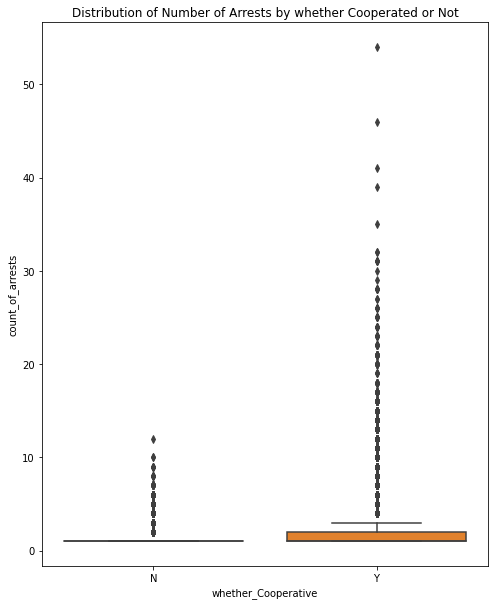

In [87]:
plt.figure(figsize=(8, 10))
sns.boxplot(data=arrests_cooperative, y = "count_of_arrests", x = "whether_Cooperative")
plt.title("Distribution of Number of Arrests by whether Cooperated or Not")

In [88]:
# check variance consistency
group_n_cooperative = arrests_cooperative.loc[arrests_cooperative.loc[:,'whether_Cooperative']=='N']['count_of_arrests']
group_y_cooperative = arrests_cooperative.loc[arrests_cooperative.loc[:,'whether_Cooperative']=='Y']['count_of_arrests']
statistic, p = stats.levene(group_n_cooperative, group_y_cooperative, center='mean')
print(f'Statistic: {statistic:.3f}, p-value: {p:.3f}')
# with p-value smaller than 0.05, the variances of two groups are inconsistent, so we apply welch's T test for unequal variances.

Statistic: 4138.082, p-value: 0.000


In [89]:
# welch's T test for unequal variances
stats.ttest_ind(group_y_cooperative, group_n_cooperative, equal_var=False)

# At an alpha significance of 0.05, there is sufficient evidence to suggest that there is a difference in the average number of police arrests between suspects whether cooperated or not.

Ttest_indResult(statistic=51.152769668185016, pvalue=0.0)

#### **T-test: Arrests of females vs males**

H0: There is no significant difference in the average number of police arrests between males and females.

HA: There is a significant difference in the average number of police arrests between males and females.

Assumptions Check:

Since n>50 for each group, we can reasonably assume that it follows a normal distribution.

In [90]:
sex_df = processed_df.groupby(['PersonID',"Sex"]).agg(Count_of_Arrests=("PersonID","count")).reset_index()
print(sex_df)

       PersonID Sex  Count_of_Arrests
0        300000   M                 1
1        300001   F                 1
2        300002   M                 1
3        300003   M                 8
4        300004   M                 1
...         ...  ..               ...
37385    337342   M                 5
37386    337343   M                 1
37387    337344   M                 1
37388    337345   M                 1
37389    337346   M                 1

[37390 rows x 3 columns]


Text(0.5, 1.0, 'Boxplot of Arrest Amount by Sex')

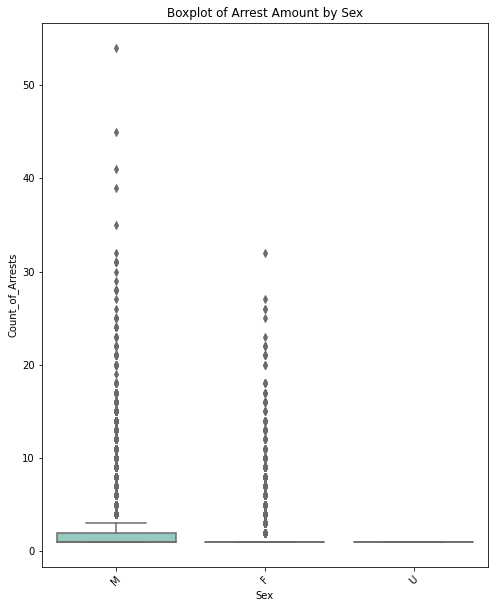

In [91]:
f = plt.figure(figsize=(8,10))
sns.boxplot(x="Sex", y="Count_of_Arrests", data=sex_df, palette="Set3")
plt.xticks(rotation=45)
plt.title("Boxplot of Arrest Amount by Sex")

In [92]:
# check variance consistency
group_s_m = sex_df.loc[sex_df.loc[:,'Sex']=='M']['Count_of_Arrests']
group_s_f = sex_df.loc[sex_df.loc[:,'Sex']=='F']['Count_of_Arrests']
statistic, p = stats.levene(group_s_m, group_s_f, center='mean')
print(f'Statistic: {statistic:.3f}, p-value: {p:.3f}')

Statistic: 28.197, p-value: 0.000


In [93]:
# welch's T test for unequal variances
stats.ttest_ind(group_s_m, group_s_f, equal_var=False)
# At an alpha significance of 0.05, there is sufficient evidence to suggest that there is a difference in the average number of police arrests between males and females

Ttest_indResult(statistic=5.3848082092215455, pvalue=7.381040021829354e-08)

In [94]:
whether_youth_df = processed_df.groupby(['PersonID',"Youth_at_arrest__under_18_years"]).agg(Count_of_Arrests=("PersonID","count")).reset_index()
print(whether_youth_df)

       PersonID  Youth_at_arrest__under_18_years  Count_of_Arrests
0        300000                      Not a youth                 1
1        300001  Youth (aged 17 years and under)                 1
2        300002                      Not a youth                 1
3        300003                      Not a youth                 8
4        300004                      Not a youth                 1
...         ...                              ...               ...
37452    337342  Youth (aged 17 years and under)                 5
37453    337343                      Not a youth                 1
37454    337344                      Not a youth                 1
37455    337345                      Not a youth                 1
37456    337346                      Not a youth                 1

[37457 rows x 3 columns]


#### **T-test: Arrests of youths vs adults**

H0: There is no significant difference in the average number of police arrests between youths and adults.

HA: There is a significant difference in the average number of police arrests between youths and adults.

Assumptions Check:

Since n>50 for each group, we can reasonably assume that it follows a normal distribution.

In [95]:
whether_youth_df = processed_df.groupby(['PersonID',"Youth_at_arrest__under_18_years"]).agg(Count_of_Arrests=("PersonID","count")).reset_index()
whether_youth_df["whether_youth"] = whether_youth_df.apply(lambda x: "N" if x.Youth_at_arrest__under_18_years=="Not a youth" else "Y", axis=1)
whether_youth_df.drop("Youth_at_arrest__under_18_years", axis=1, inplace=True)
print(whether_youth_df)

       PersonID  Count_of_Arrests whether_youth
0        300000                 1             N
1        300001                 1             Y
2        300002                 1             N
3        300003                 8             N
4        300004                 1             N
...         ...               ...           ...
37452    337342                 5             Y
37453    337343                 1             N
37454    337344                 1             N
37455    337345                 1             N
37456    337346                 1             N

[37457 rows x 3 columns]


Text(0.5, 1.0, 'Boxplot of Arrest Amount by Whether one is a Youth or Not')

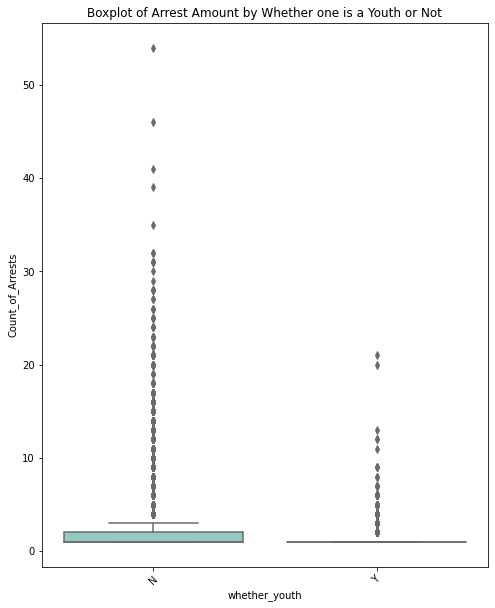

In [96]:
f = plt.figure(figsize=(8,10))
sns.boxplot(x="whether_youth", y="Count_of_Arrests", data=whether_youth_df, palette="Set3")
plt.xticks(rotation=45)
plt.title("Boxplot of Arrest Amount by Whether one is a Youth or Not")

In [97]:
# check variance consistency
group_youth = whether_youth_df.loc[whether_youth_df.loc[:,'whether_youth']=='Y']['Count_of_Arrests']
group_non_youth = whether_youth_df.loc[whether_youth_df.loc[:,'whether_youth']=='N']['Count_of_Arrests']
statistic, p = stats.levene(group_youth, group_non_youth, center='mean')
print(f'Statistic: {statistic:.3f}, p-value: {p:.3f}')

Statistic: 100.008, p-value: 0.000


In [98]:
# welch's T test for unequal variances
stats.ttest_ind(group_youth, group_non_youth, equal_var=False)
# At an alpha significance of 0.05, there is sufficient evidence to suggest that there is a difference in the average number of police arrests between youths and adults. 

Ttest_indResult(statistic=-10.233359483537276, pvalue=3.688918451540259e-24)

### **Power Analysis**

In [99]:
import statsmodels.stats.power as smp

In [100]:
# instantiate power function
power_analysis = smp.FTestAnovaPower(k=8, alpha=0.05)

# array of sample sizes and effect sizes
effect_sizes = np.array([0.2, 0.5, 0.8])
sample_sizes = np.array(range(10, 1000, 5))

<ipython-input-101-0e72e5071838>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


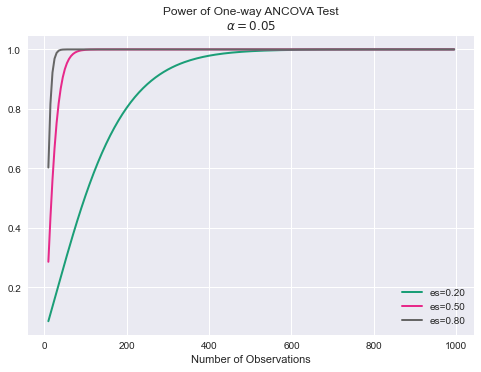

In [101]:
plt.style.use('seaborn')
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
fig = power_analysis.plot_power(
    dep_var='nobs', nobs=sample_sizes,  
    effect_size=effect_sizes, alpha=0.05, ax=ax, 
    title='Power of One-way ANCOVA Test\n$\\alpha = 0.05$')

### **ANCOVA: Number of Arrests by Perceived Race**

**Research Question 1:** 

How does perceived race influence arrest outcome, controlling for the number of arrests in the previous year?

- H0: There is no significant difference in the number of arrests by perceived race, while controlling for the number of arrests in the previous year in 2020.


- HA: There is a significant difference in the number of arrests by perceived race, while controlling for the number of arrests in the previous year in 2020.

#### **Assumption Check: Normality Test**

To check for the Normality of the number of arrests, we will conduct a Kolmogorov-Smirnov test.

In [102]:
def get_significance(p):
  """Returns the significance of a p-values as a string of stars."""
  if p <= 0.001:
    return '***'
  elif p <= 0.01:
    return '**'
  elif p <= 0.05:
    return '*'
  elif p <= 0.1:
    return '.'
  else:
    return ''

def round_p_value(p):
  """Round a small p-value so that it is human-readable."""
  if p < 0.001:
    return '<0.001'
  else:
    return f'{p:5.3}'

In [103]:
# normality test for count of arrests in 2021 (dv) by perceived race (iv)

races = list(merged_arrests["Perceived_Race"].unique()) # get list of races

for race in races:
  subset = merged_arrests[merged_arrests["Perceived_Race"]==race]
  stat, p = stats.kstest(subset["count_of_arrests_2021"], "norm")
  rounded_p = round_p_value(p)
  sig = get_significance(p)
  print(f"Subset: {race}, statistic: {stat:.3f}, pvalue:", rounded_p, sig)
  if p < 0.05:
    print("Normality Assumption Violated")
    print()
  else:
    print("Assumption Satisfied")
    print()

Subset: White, statistic: 0.841, pvalue: <0.001 ***
Normality Assumption Violated

Subset: South Asian, statistic: 0.841, pvalue: <0.001 ***
Normality Assumption Violated

Subset: East/Southeast Asian, statistic: 0.841, pvalue: <0.001 ***
Normality Assumption Violated

Subset: Middle-Eastern, statistic: 0.841, pvalue: <0.001 ***
Normality Assumption Violated

Subset: Black, statistic: 0.841, pvalue: <0.001 ***
Normality Assumption Violated

Subset: Unknown or Legacy, statistic: 0.841, pvalue: <0.001 ***
Normality Assumption Violated

Subset: Latino, statistic: 0.841, pvalue: <0.001 ***
Normality Assumption Violated

Subset: Indigenous, statistic: 0.841, pvalue: <0.001 ***
Normality Assumption Violated



#### **Assumption Check: Homodescasity of Equal Variances**

To check for the homogeneity of equal variances of the number of bookings across each racial subgroup, we will use Levene's test:


*   Null: There is equal variances.
*   Alternative: There is no equal variances.


In [104]:
# get list of races
races = list(merged_arrests["Perceived_Race"].unique())

# Split the data into groups based on perceived race
race_groups = [merged_arrests[merged_arrests['Perceived_Race'] == race]['count_of_arrests_2021'] for race in races]

# Perform Levene's test
statistic, p_value = stats.levene(*race_groups)
rounded_p = round_p_value(p_value)
sig = get_significance(p_value)


print(f"Levene's test statistic: {statistic:.3f}")
print("p-value:", rounded_p, sig)
print()

if p_value < 0.05:
  print("The homodescasity assumption is violated.")
else:
  print("The homodescasity assumption has been satisfied.")

Levene's test statistic: 81.078
p-value: <0.001 ***

The homodescasity assumption is violated.


#### **Assumption Check: Linearity (Covariate)**

The relationship between the covariate and the dependent variable at each group of the independent variable should be linear. The scatterplot of covariate and dependent variable at each group of the independent variable can be used to assess this assumption

Text(0.5, 1.0, 'Linearity Assumption Check')

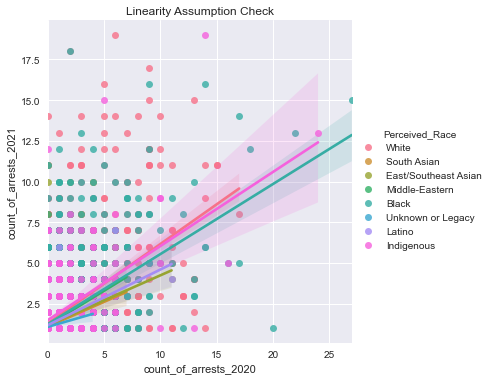

In [105]:
# Generate scatterplot
sns.lmplot(x="count_of_arrests_2020", y="count_of_arrests_2021", hue="Perceived_Race", data=merged_arrests)
plt.title("Linearity Assumption Check")

We are see that the relationship is non-linear, such that the homogeneity of linear assumption is violated. However, for the purpose of this report, we will proceed with the ANCOVA test.

#### **Assumption Check: Homogeneity of Regression Slopes**

We will test this by looking at the significance of the interaction term between perceived race and count of arrests in 2020 in an F test using ANOVA.

In [106]:
assumption_model = ols('count_of_arrests_2021 ~ Perceived_Race + count_of_arrests_2020 + Perceived_Race:count_of_arrests_2020', data=merged_arrests).fit()

In [107]:
assumption_result = sm.stats.anova_lm(assumption_model, type=2)
assumption_result

,df,sum_sq,mean_sq,F,PR(>F)
Perceived_Race,7.0,772.957772,110.422539,105.904690,3.890959e-153
count_of_arrests_2020,1.0,6835.463342,6835.463342,6555.795856,0.000000e+00
Perceived_Race:count_of_arrests_2020,7.0,71.062185,10.151741,9.736390,3.648383e-12
Residual,21598.0,22519.361570,1.042660,NaN,NaN


We can see that the interaction term between the categorical independent variable and covariate (count of arrests for 2020) is significant, therefore, the homogeneity of regression slopes is violated. However, for the purpose of this report, we will proceed with the ANCOVA test.

#### **Running ANCOVA Test**

In [108]:
# Run ANCOVA analysis with one covariate 
ancova_model = ols('count_of_arrests_2021 ~ Perceived_Race + count_of_arrests_2020', data=merged_arrests).fit()

In [109]:
# Print the summary of the model
print(ancova_model.summary())

                              OLS Regression Results                             
Dep. Variable:     count_of_arrests_2021   R-squared:                       0.252
Model:                               OLS   Adj. R-squared:                  0.252
Method:                    Least Squares   F-statistic:                     909.6
Date:                   Sun, 16 Apr 2023   Prob (F-statistic):               0.00
Time:                           15:24:37   Log-Likelihood:                -31146.
No. Observations:                  21614   AIC:                         6.231e+04
Df Residuals:                      21605   BIC:                         6.238e+04
Df Model:                              8                                         
Covariance Type:               nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

At an alpha significance of 0.05, results of the ANCOVA suggests that there is significant difference in the number of arrests by perceived race in 2021, while controlling for previous arrests occurring in 2020 (p<0.001).

### **Logistic Regression**

In [110]:
import sklearn.linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics

from sklearn.metrics import confusion_matrix

The median of the count of arrests is 1.0


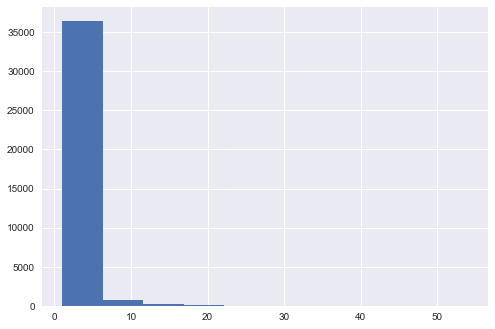

In [111]:
# check the distribution of integrated arrest counts, and recode the outcome variable into binary
logistic_df = processed_df.groupby(["PersonID", "Sex", "Youth_at_arrest__under_18_years"]).agg({"PersonID":"count",
                                                                                                                 'Actions_at_arrest___Concealed_i':"sum",
                                                                                                                 'Actions_at_arrest___Combative__':"sum", 'Actions_at_arrest___Resisted__d':"sum",
                                                                                                                 'Actions_at_arrest___Mental_inst':"sum", 'Actions_at_arrest___Assaulted_o':"sum",
                                                                                                                 'Actions_at_arrest___Cooperative':"sum"})
logistic_df.rename(columns={"PersonID":"count_of_arrests"}, inplace=True)
plt.hist(logistic_df["count_of_arrests"])
logistic_df.reset_index(inplace=True)
print("The median of the count of arrests is",logistic_df["count_of_arrests"].median())
arrest_median = logistic_df["count_of_arrests"].median()
logistic_df["whether_arrested"] = logistic_df.apply(lambda x: 1 if x.count_of_arrests > arrest_median else 0, axis=1)

In [112]:
# one-hot encoding for the perceived race and sex, and record the age into adult vs juvenile.
logistic_df = pd.get_dummies(logistic_df, columns=["Sex"])
logistic_df["whether_youth"] = logistic_df.apply(lambda x: 0 if x.Youth_at_arrest__under_18_years=="Not a youth" else 1, axis=1)
logistic_df.drop(["Youth_at_arrest__under_18_years","count_of_arrests"], axis=1, inplace=True)
logistic_df

,PersonID,Actions_at_arrest___Concealed_i,Actions_at_arrest___Combative__,Actions_at_arrest___Resisted__d,Actions_at_arrest___Mental_inst,Actions_at_arrest___Assaulted_o,Actions_at_arrest___Cooperative,whether_arrested,Sex_F,Sex_M,Sex_U,whether_youth
0,300000,0,0,0,0,0,0,0,0,1,0,0
1,300001,0,0,0,0,0,0,0,1,0,0,1
2,300002,0,0,0,0,0,1,0,0,1,0,0
3,300003,0,0,0,1,0,2,1,0,1,0,0
4,300004,0,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
37494,337342,0,0,1,0,0,3,1,0,1,0,1
37495,337343,0,0,0,0,0,1,0,0,1,0,0
37496,337344,0,0,0,0,0,0,0,0,1,0,0
37497,337345,0,0,0,0,0,1,0,0,1,0,0


<AxesSubplot: >

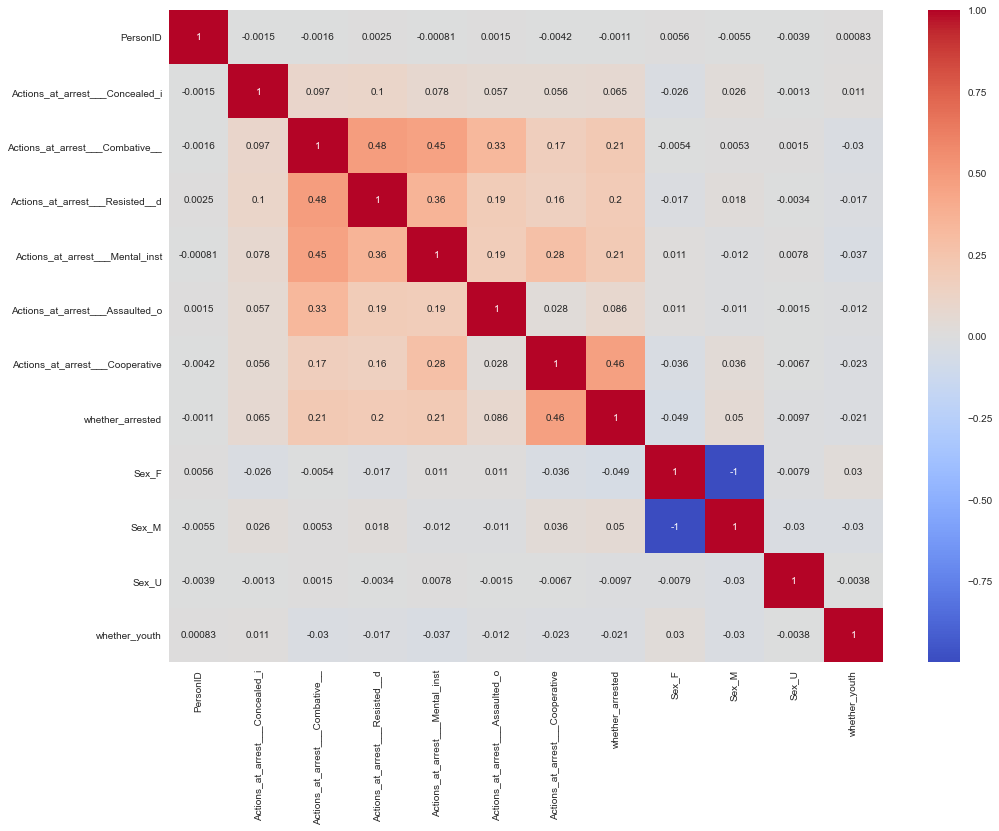

In [113]:
#check the correlation matrix
corr_matrix = logistic_df.corr()
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

In [114]:
# there's mulicollinerity, and we'll remove the Sex_F from our dataset, additionally, as the sample size of people with other genders is too small, we'll also remove that from our dataset.
logistic_df.drop(columns=["Sex_F","Sex_U"],  axis=1, inplace=True)

In [115]:
# split dataset into training and test dataset
y = logistic_df["whether_arrested"]
X = logistic_df.drop(columns=["PersonID","whether_arrested"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

Optimization terminated successfully.
         Current function value: 0.420239
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:       whether_arrested   No. Observations:                29999
Model:                          Logit   Df Residuals:                    29990
Method:                           MLE   Df Model:                            8
Date:                Sun, 16 Apr 2023   Pseudo R-squ.:                  0.2911
Time:                        15:24:40   Log-Likelihood:                -12607.
converged:                       True   LL-Null:                       -17783.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -3.0211      0.046    -65.339  

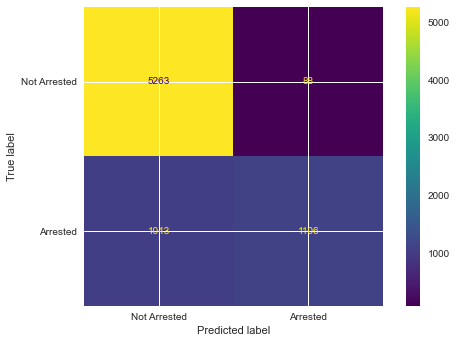

Accuracy: 0.8492


In [116]:
# sklearn

# fit the model
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

# Extract coefficients and intercept from logistic regression model
coef = logreg.coef_[0]
intercept = logreg.intercept_

# Create statsmodels Logit object with same coefficients and intercept
logit_model2 = sm.Logit(y_train, sm.add_constant(X_train))
start_params = np.concatenate((intercept, coef))
logit_model_fit = logit_model2.fit(start_params=start_params)

# Print summary table
print(logit_model_fit.summary())

# Take the exponential of the odds ratio
params = logit_model_fit.params
odds_ratios = np.exp(params)

# Print summary table with odds ratios
print(np.exp(logit_model_fit.params))

# make predictions
y_pred = logreg.predict(X_test)

# create confusion matrix and the plot
cm = metrics.confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
# Get the confusion matrix plot
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Arrested', 'Arrested'])
cm_display.plot()
plt.show()

# calculate accuracy rate
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

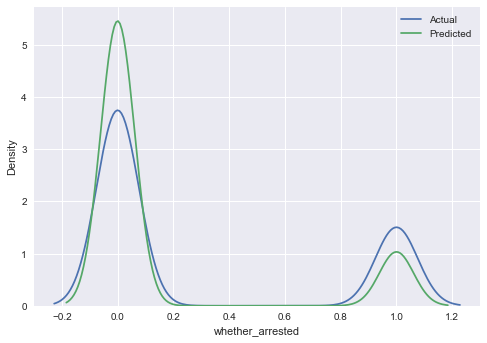

In [117]:
sns.kdeplot(y_test, label='Actual')
sns.kdeplot(y_pred, label='Predicted')
plt.legend()
plt.show()

#### **Prediction interval**

In [118]:
mod = sm.Logit.from_formula('whether_arrested ~ Actions_at_arrest___Resisted__d', logistic_df)
res = mod.fit()
me = res.get_margeff()

Optimization terminated successfully.
         Current function value: 0.574583
         Iterations 5


In [119]:
Λ = lambda x: stats.logistic().cdf(x)
λ = lambda x: stats.logistic().pdf(x)

β_ = res.params.values.reshape(-1, 1)
V_ = res.cov_params().values

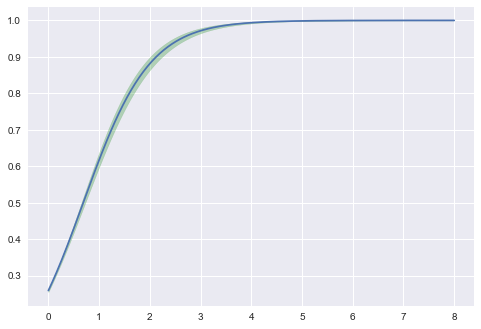

In [120]:
Λ = lambda x: stats.logistic().cdf(x)
λ = lambda x: stats.logistic().pdf(x)

β_ = res.params.values.reshape(-1, 1)
V_ = res.cov_params().values

x_resisted = np.linspace(logistic_df.Actions_at_arrest___Resisted__d.min(), logistic_df.Actions_at_arrest___Resisted__d.max(), 300)
xx = np.column_stack((np.ones(300), x_resisted))

def var_πs(xx, β, V_):
    α = λ(xx.dot(β))**2
    out = np.empty((300, 1))
    for i, x in enumerate(xx):
        out[i] = x.T.dot(V_).dot(x)
    return α * out

πs = Λ(xx.dot(β_))
vv = np.sqrt(var_πs(xx, β_, V_))

plt.plot(xx[:, 1], πs)
plt.fill_between(xx[:, 1], (πs - 1.96*vv).ravel(), (πs + 1.96*vv).ravel(),
                 alpha=.25, color='g')
plt.show()